# Spanish Electricity Pool Forecasting: Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, pearsonr,  linregress as linreg

from sklearn.preprocessing import MinMaxScaler,StandardScaler


In [3]:
import config
sns.set(
    rc=config.set_plot_features(), style="darkgrid"
       )

# 1. Input and prepare data

In [4]:
PATH = './data/'
infile1 = 'quand_daily.csv'
infile2 = 'esios_daily.csv'
outfile = 'data_spot_price_forecasting.csv'

## 1.1. Load financial data

In [5]:
fin_data = pd.read_csv(PATH + infile1, parse_dates = ["date"], index_col=["date"])
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1986 entries, 2014-01-02 to 2019-06-10
Data columns (total 3 columns):
EUA_CO2      1986 non-null float64
coal_API2    1986 non-null float64
NG_TTF       1986 non-null float64
dtypes: float64(3)
memory usage: 62.1 KB


## 1.2. Load ESIOS data

In [6]:
esios_data = pd.read_csv(PATH + infile2, parse_dates = ["date"], index_col=["date"])
esios_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2014-01-01 to 2019-06-11
Data columns (total 8 columns):
datetime        39727 non-null object
datetime_utc    39727 non-null object
geo_id          39727 non-null int64
geo_name        39727 non-null object
tz_time         39727 non-null object
value           39727 non-null float64
indicador       39727 non-null object
idx             39727 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 2.7+ MB


## 1.3 Convert ESIOS format
Pivot column "indicator" to convert a long dataset to a wide one, also filter geo

In [7]:
esios_data.groupby(["indicador", "geo_id"]).size()

indicador                                           geo_id
Generación programada P48 Biomasa                   8741      1988
Generación programada P48 Carbón                    8741      1988
Generación programada P48 Ciclo combinado           8741      1988
Generación programada P48 Cogeneración              8741      1988
Generación programada P48 Consumo bombeo            8741      1960
Generación programada P48 Exportación Total         8741      1988
Generación programada P48 Eólica                    8741      1988
Generación programada P48 Gas Natural Cogeneración  8741      1988
Generación programada P48 Hidráulica UGH            8741      1988
Generación programada P48 Hidráulica no UGH         8741      1988
Generación programada P48 Importación Total         8741      1988
Generación programada P48 Nuclear                   8741      1988
Generación programada P48 Solar fotovoltaica        8741      1988
Generación programada P48 Solar térmica             8741      1988
Gen

In [8]:
esios_data[(esios_data['indicador'] =='Precio mercado SPOT Diario')].groupby(["geo_id", "geo_name"]).size()

geo_id  geo_name
1       Portugal    1988
2       Francia     1988
3       España      1988
dtype: int64

In [9]:
esios_data = esios_data[esios_data["geo_id"].isin([8741, 3])]
esios_data[(esios_data['indicador'] =='Precio mercado SPOT Diario')].groupby(["geo_id", "geo_name"]).size()

geo_id  geo_name
3       España      1988
dtype: int64

In [10]:
esios_rename_dict = {'Precio mercado SPOT Diario': 'spot_price',
    'Generación programada P48 Exportación Total': 'GP48_export',
    'Generación programada P48 Importación Total': 'GP48_import',
    'Generación programada P48 Cogeneración': 'GP48_cogen',
    'Generación programada P48 Eólica': 'GP48_wind',
    'Generación programada P48 Carbón': 'GP48_coal',
    'Generación programada P48 Consumo bombeo': 'GP48_pumping_con',
    'Generación programada P48 Gas Natural Cogeneración': 'GP48_cogen_ng',
    'Generación programada P48 Biomasa': 'GP48_biomass',
    'Generación programada P48 Solar térmica': 'GP48_thermosolar',
    'Generación programada P48 Solar fotovoltaica': 'GP48_PV',
    'Generación programada P48 Ciclo combinado': 'GP48_CC',
    'Generación programada P48 Turbinación bombeo': 'GP48_pumping_tur',
    'Generación programada P48 Nuclear': 'GP48_nuclear',
    'Generación programada P48 Hidráulica no UGH': 'GP48_hydro_noUGH',
    'Generación programada P48 Hidráulica UGH': 'GP48_hydro_UGH',
    'Generación programada P48 UGH + no UGH': 'GP48_hydro_total',
    'Generación programada PBF total': 'GP48_total',
    'Demanda real': 'Demand_actual',
    'Demanda programada': 'Demad_schedulled',
    'Demanda prevista': 'Demand_forecasted'}

In [11]:
esios_data_wide = esios_data.pivot(columns='indicador', values='value').rename(columns=esios_rename_dict)
esios_data_wide['spot_price'] = esios_data_wide['spot_price']
esios_data_wide.head()

indicador,GP48_biomass,GP48_coal,GP48_CC,GP48_cogen,GP48_pumping_con,GP48_export,GP48_wind,GP48_cogen_ng,GP48_hydro_UGH,GP48_hydro_noUGH,GP48_import,GP48_nuclear,GP48_PV,GP48_thermosolar,GP48_pumping_tur,GP48_hydro_total,GP48_total,spot_price
date,,,,,,,,,,,,,,,,,,
2014-01-01,13177.9,18848.0,44044.5,49558.4,-57532.2,-41923.3,249020.4,49558.4,54128.3,20988.8,20632.4,146378.0,10106.4,377.4,4029.1,75117.1,586167.8,5.808750
2014-01-02,13236.7,31339.4,41777.8,74108.9,-28593.1,-37164.0,257373.7,74108.9,69150.3,21097.7,39650.4,146318.4,6627.4,203.4,17582.6,90248.0,642771.8,25.280833
2014-01-03,13835.7,36810.9,42092.0,79653.9,-31652.8,-28187.9,235044.5,79653.9,76930.1,22436.9,35496.3,146293.3,10278.3,1480.8,17718.6,99367.0,658078.5,39.924167
2014-01-04,12747.3,22943.9,24457.4,59390.3,-60941.8,-43815.0,300859.5,59390.3,83123.3,21338.1,33100.7,146377.6,9103.7,577.5,5090.9,104461.4,680564.6,4.992083
2014-01-05,12506.2,19131.3,33155.6,58413.6,-39994.0,-45133.1,263473.8,58413.6,96505.4,21551.2,29632.9,122227.2,13596.4,3433.0,13072.6,118056.6,644494.7,4.091667


## 1.4 Merge data and set daily index

In [12]:
esios_select = ['spot_price', 'GP48_total', 'GP48_export', 'GP48_import', 'GP48_cogen', 'GP48_wind', 'GP48_coal', 
                'GP48_biomass', 'GP48_thermosolar', 'GP48_PV', 'GP48_CC','GP48_nuclear',
                'GP48_pumping_con', 'GP48_pumping_tur', 'GP48_hydro_total']
data = esios_data_wide[esios_select].merge(fin_data, how='left', left_index=True, right_index=True)\
    .asfreq("D")
data[['GP48_pumping_con', 'GP48_pumping_tur','GP48_export', 'GP48_import']] =\
    data[['GP48_pumping_con', 'GP48_pumping_tur','GP48_export', 'GP48_import']].fillna(0.0)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1988 entries, 2014-01-01 to 2019-06-11
Freq: D
Data columns (total 18 columns):
spot_price          1988 non-null float64
GP48_total          1988 non-null float64
GP48_export         1988 non-null float64
GP48_import         1988 non-null float64
GP48_cogen          1988 non-null float64
GP48_wind           1988 non-null float64
GP48_coal           1988 non-null float64
GP48_biomass        1988 non-null float64
GP48_thermosolar    1988 non-null float64
GP48_PV             1988 non-null float64
GP48_CC             1988 non-null float64
GP48_nuclear        1988 non-null float64
GP48_pumping_con    1988 non-null float64
GP48_pumping_tur    1988 non-null float64
GP48_hydro_total    1988 non-null float64
EUA_CO2             1986 non-null float64
coal_API2           1986 non-null float64
NG_TTF              1986 non-null float64
dtypes: float64(18)
memory usage: 295.1 KB


In [13]:
data.head()

,spot_price,GP48_total,GP48_export,GP48_import,GP48_cogen,GP48_wind,GP48_coal,GP48_biomass,GP48_thermosolar,GP48_PV,GP48_CC,GP48_nuclear,GP48_pumping_con,GP48_pumping_tur,GP48_hydro_total,EUA_CO2,coal_API2,NG_TTF
date,,,,,,,,,,,,,,,,,,
2014-01-01,5.808750,586167.8,-41923.3,20632.4,49558.4,249020.4,18848.0,13177.9,377.4,10106.4,44044.5,146378.0,-57532.2,4029.1,75117.1,NaN,NaN,NaN
2014-01-02,25.280833,642771.8,-37164.0,39650.4,74108.9,257373.7,31339.4,13236.7,203.4,6627.4,41777.8,146318.4,-28593.1,17582.6,90248.0,4.740000,76.65,27.302
2014-01-03,39.924167,658078.5,-28187.9,35496.3,79653.9,235044.5,36810.9,13835.7,1480.8,10278.3,42092.0,146293.3,-31652.8,17718.6,99367.0,4.720000,76.65,27.213
2014-01-04,4.992083,680564.6,-43815.0,33100.7,59390.3,300859.5,22943.9,12747.3,577.5,9103.7,24457.4,146377.6,-60941.8,5090.9,104461.4,4.693333,76.65,27.266
2014-01-05,4.091667,644494.7,-45133.1,29632.9,58413.6,263473.8,19131.3,12506.2,3433.0,13596.4,33155.6,122227.2,-39994.0,13072.6,118056.6,4.666667,76.65,27.319


In [14]:
data.isna().sum()

spot_price          0
GP48_total          0
GP48_export         0
GP48_import         0
GP48_cogen          0
GP48_wind           0
GP48_coal           0
GP48_biomass        0
GP48_thermosolar    0
GP48_PV             0
GP48_CC             0
GP48_nuclear        0
GP48_pumping_con    0
GP48_pumping_tur    0
GP48_hydro_total    0
EUA_CO2             2
coal_API2           2
NG_TTF              2
dtype: int64

In [15]:
data.tail()

,spot_price,GP48_total,GP48_export,GP48_import,GP48_cogen,GP48_wind,GP48_coal,GP48_biomass,GP48_thermosolar,GP48_PV,GP48_CC,GP48_nuclear,GP48_pumping_con,GP48_pumping_tur,GP48_hydro_total,EUA_CO2,coal_API2,NG_TTF
date,,,,,,,,,,,,,,,,,,
2019-06-07,41.634583,675257.0,-48161.6,48481.9,83913.3,188503.4,14662.9,7606.9,30163.2,31696.5,138417.8,133380.0,-12372.9,3509.6,60095.4,24.44,54.600000,11.520000
2019-06-08,46.252083,608638.5,-48009.5,49284.6,80241.1,103749.9,7694.7,7512.1,27418.0,30377.9,157681.4,141586.0,-3487.5,41.0,51180.7,24.67,54.833333,11.614667
2019-06-09,43.298333,553773.9,-46040.6,36767.6,77159.7,86084.9,7485.0,6968.7,28502.1,29279.0,126956.2,158626.7,-4772.3,401.7,49872.7,24.90,55.066667,11.709333
2019-06-10,44.737083,618326.3,-23895.6,54379.8,81092.0,119406.9,7306.7,6728.8,29733.2,31263.6,127278.2,165883.1,-4930.9,382.5,49497.3,25.13,55.300000,11.804000
2019-06-11,45.362917,647137.1,-18619.2,43113.5,82856.6,137833.3,12517.9,5826.9,30625.0,27955.7,133907.0,167340.8,-2288.0,1327.1,51071.6,NaN,NaN,NaN


In [16]:
data[["spot_price", "GP48_total"]].describe().T

,count,mean,std,min,25%,50%,75%,max
spot_price,1988.0,48.649214,13.446030,0.477917,42.089687,50.0425,57.986979,91.883333
GP48_total,1988.0,647735.920573,69786.736755,457837.600000,598947.875000,649111.7000,691021.975000,875595.100000


In [17]:
data.corr()

,spot_price,GP48_total,GP48_export,GP48_import,GP48_cogen,GP48_wind,GP48_coal,GP48_biomass,GP48_thermosolar,GP48_PV,GP48_CC,GP48_nuclear,GP48_pumping_con,GP48_pumping_tur,GP48_hydro_total,EUA_CO2,coal_API2,NG_TTF
spot_price,1.000000,0.128934,0.145131,0.137698,0.570463,-0.482753,0.659477,0.038263,0.020641,-0.051864,0.593574,-0.098038,0.617498,-0.189251,-0.447086,0.352814,0.451408,0.339950
GP48_total,0.128934,1.000000,-0.433545,-0.346096,0.219285,0.366733,0.333341,0.134308,-0.183415,-0.249142,0.295966,0.184255,0.065277,0.266976,0.178104,-0.123294,-0.035278,0.112334
GP48_export,0.145131,-0.433545,1.000000,0.417133,0.050959,-0.445605,0.057996,0.080414,0.261887,0.246528,-0.003282,-0.118771,0.301160,-0.189790,-0.050918,0.068673,0.009799,-0.008028
GP48_import,0.137698,-0.346096,0.417133,1.000000,0.497771,-0.219122,-0.184037,-0.499360,0.012369,0.009544,0.071401,-0.036505,0.235499,-0.124040,-0.114430,0.221346,0.171918,-0.316718
GP48_cogen,0.570463,0.219285,0.050959,0.497771,1.000000,-0.085050,0.125364,-0.454152,-0.054772,-0.100860,0.442435,-0.080001,0.447127,-0.119276,-0.230199,0.494694,0.337029,-0.047655
GP48_wind,-0.482753,0.366733,-0.445605,-0.219122,-0.085050,1.000000,-0.486498,-0.095681,-0.344782,-0.351962,-0.461797,0.070124,-0.586987,0.117905,0.098215,0.017316,-0.083932,0.024961
GP48_coal,0.659477,0.333341,0.057996,-0.184037,0.125364,-0.486498,1.000000,0.434035,0.057912,-0.046977,0.454696,-0.107216,0.445825,-0.082392,-0.374778,-0.244428,0.101954,0.174873
GP48_biomass,0.038263,0.134308,0.080414,-0.499360,-0.454152,-0.095681,0.434035,1.000000,0.048595,0.016934,-0.079358,-0.073687,-0.058571,0.090643,0.000736,-0.314124,-0.304291,0.303689
GP48_thermosolar,0.020641,-0.183415,0.261887,0.012369,-0.054772,-0.344782,0.057912,0.048595,1.000000,0.916655,0.035706,-0.100777,0.317923,-0.329041,-0.121956,-0.033386,-0.044962,-0.235109
GP48_PV,-0.051864,-0.249142,0.246528,0.009544,-0.100860,-0.351962,-0.046977,0.016934,0.916655,1.000000,-0.034384,-0.096004,0.281800,-0.283922,-0.007038,-0.010817,-0.085131,-0.238436


In [18]:
data.head()

,spot_price,GP48_total,GP48_export,GP48_import,GP48_cogen,GP48_wind,GP48_coal,GP48_biomass,GP48_thermosolar,GP48_PV,GP48_CC,GP48_nuclear,GP48_pumping_con,GP48_pumping_tur,GP48_hydro_total,EUA_CO2,coal_API2,NG_TTF
date,,,,,,,,,,,,,,,,,,
2014-01-01,5.808750,586167.8,-41923.3,20632.4,49558.4,249020.4,18848.0,13177.9,377.4,10106.4,44044.5,146378.0,-57532.2,4029.1,75117.1,NaN,NaN,NaN
2014-01-02,25.280833,642771.8,-37164.0,39650.4,74108.9,257373.7,31339.4,13236.7,203.4,6627.4,41777.8,146318.4,-28593.1,17582.6,90248.0,4.740000,76.65,27.302
2014-01-03,39.924167,658078.5,-28187.9,35496.3,79653.9,235044.5,36810.9,13835.7,1480.8,10278.3,42092.0,146293.3,-31652.8,17718.6,99367.0,4.720000,76.65,27.213
2014-01-04,4.992083,680564.6,-43815.0,33100.7,59390.3,300859.5,22943.9,12747.3,577.5,9103.7,24457.4,146377.6,-60941.8,5090.9,104461.4,4.693333,76.65,27.266
2014-01-05,4.091667,644494.7,-45133.1,29632.9,58413.6,263473.8,19131.3,12506.2,3433.0,13596.4,33155.6,122227.2,-39994.0,13072.6,118056.6,4.666667,76.65,27.319


# 2. Basic Feature Engineering 

## 2.1 Time features

In [19]:
data["year"] = data.index.year.astype(int)
data["qtr"] = data.index.quarter.astype(int)
data["mon"] = data.index.month.astype(int)
data["week"] = data.index.week.astype(int)
data["weekday"] = data.index.weekday.astype(int)

data["qtr_idx"] = data["year"]*10+data["qtr"]
data["mon_idx"] = data["year"]*100+data["mon"]
data["flg_isWeekend"] = np.where(data["weekday"].isin([5,6]),1,0)

data[["year","qtr","mon","week","weekday","flg_isWeekend"]].head(10)

,year,qtr,mon,week,weekday,flg_isWeekend
date,,,,,,
2014-01-01,2014,1,1,1,2,0
2014-01-02,2014,1,1,1,3,0
2014-01-03,2014,1,1,1,4,0
2014-01-04,2014,1,1,1,5,1
2014-01-05,2014,1,1,1,6,1
2014-01-06,2014,1,1,2,0,0
2014-01-07,2014,1,1,2,1,0
2014-01-08,2014,1,1,2,2,0
2014-01-09,2014,1,1,2,3,0


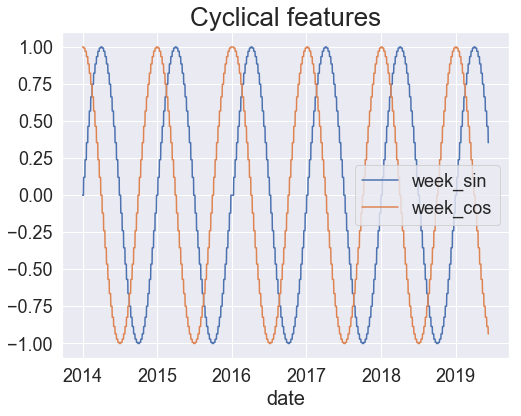

In [20]:
features_time = ["week_sin","week_cos","weekday_sin","weekday_cos"]

data["week_sin"] = np.sin((data['week']-1)*(2*np.pi/52))
data["week_cos"] = np.cos((data['week']-1)*(2*np.pi/52))

data["weekday_sin"] = np.sin((data['weekday'])*(2*np.pi/7))
data["weekday_cos"] = np.cos((data['weekday'])*(2*np.pi/7))

data[["week_sin", "week_cos"]].plot(figsize=(8,6))
plt.title("Cyclical features")
plt.show()

## 2.2. Derived features

### 2.2.1. Compute generation share by techology

In [21]:
pct_compute =['GP48_export', 'GP48_import',
 'GP48_cogen','GP48_wind', 'GP48_coal',
 'GP48_biomass', 'GP48_thermosolar', 'GP48_PV',
 'GP48_CC', 'GP48_nuclear',
 'GP48_pumping_con','GP48_pumping_tur', 'GP48_hydro_total']

features_gen_pct = [x + "_pct" for x in pct_compute]

data[features_gen_pct] = data[pct_compute].divide(data["GP48_total"], axis=0)

data[features_gen_pct].head()

,GP48_export_pct,GP48_import_pct,GP48_cogen_pct,GP48_wind_pct,GP48_coal_pct,GP48_biomass_pct,GP48_thermosolar_pct,GP48_PV_pct,GP48_CC_pct,GP48_nuclear_pct,GP48_pumping_con_pct,GP48_pumping_tur_pct,GP48_hydro_total_pct
date,,,,,,,,,,,,,
2014-01-01,-0.071521,0.035199,0.084546,0.424828,0.032155,0.022481,0.000644,0.017241,0.075140,0.249720,-0.098150,0.006874,0.128149
2014-01-02,-0.057818,0.061687,0.115296,0.400412,0.048757,0.020593,0.000316,0.010311,0.064996,0.227637,-0.044484,0.027354,0.140404
2014-01-03,-0.042834,0.053939,0.121040,0.357168,0.055937,0.021024,0.002250,0.015619,0.063962,0.222304,-0.048099,0.026925,0.150996
2014-01-04,-0.064380,0.048637,0.087266,0.442073,0.033713,0.018730,0.000849,0.013377,0.035937,0.215083,-0.089546,0.007480,0.153492
2014-01-05,-0.070029,0.045979,0.090635,0.408807,0.029684,0.019405,0.005327,0.021096,0.051444,0.189648,-0.062055,0.020283,0.183177


### 2.2.2. Compute price quantiles by quater and a weekend indicator

In [22]:
def apply_quantiles(x, q25, q50, q75):
    if x < q25:
        return 0
    elif x<q50:
        return 1
    elif x<q75:
        return 2
    else:
        return 3

In [23]:
data_q_spot = data[["spot_price", "year", "qtr", "flg_isWeekend"]].copy() 
q_cols = []

for q in [0.25, 0.5, 0.75]:
    q_grp = data.groupby(["year", "qtr", "flg_isWeekend"])["spot_price"].quantile(q).to_frame("q_" + str(q*100))
    data_q_spot = data_q_spot.merge(q_grp, "left", left_on=["year", "qtr", "flg_isWeekend"], right_index=True)
    q_cols.append("q_" + str(q*100))

data_q_spot["spot_price_q"] = data_q_spot[["spot_price"] + q_cols].apply(lambda x: apply_quantiles(x[0], x[1], x[2], x[3]), axis=1)
data_q_spot.tail(10)

,spot_price,year,qtr,flg_isWeekend,q_25.0,q_50.0,q_75.0,spot_price_q
date,,,,,,,,
2019-06-02,47.817500,2019,2,1,41.862396,46.278542,50.587812,2
2019-06-03,53.415000,2019,2,0,47.107812,51.090625,54.013229,2
2019-06-04,49.411250,2019,2,0,47.107812,51.090625,54.013229,1
2019-06-05,45.327083,2019,2,0,47.107812,51.090625,54.013229,0
2019-06-06,43.824167,2019,2,0,47.107812,51.090625,54.013229,0
2019-06-07,41.634583,2019,2,0,47.107812,51.090625,54.013229,0
2019-06-08,46.252083,2019,2,1,41.862396,46.278542,50.587812,1
2019-06-09,43.298333,2019,2,1,41.862396,46.278542,50.587812,1
2019-06-10,44.737083,2019,2,0,47.107812,51.090625,54.013229,0


In [24]:
data_q_spot.groupby(["year", "qtr", "flg_isWeekend"])[q_cols].mean()

q_25.0     q_50.0     q_75.0
year qtr flg_isWeekend                                 
2014 1   0              16.506146  32.780417  41.180937
         1               6.981667  18.232292  26.199271
     2   0              33.950833  43.835833  51.076250
         1              20.692396  38.763958  44.266250
     3   0              50.697500  54.060000  58.232812
         1              43.957396  46.515000  53.657500
     4   0              45.510833  52.576042  57.720938
         1              36.828021  45.398958  48.643125
2015 1   0              42.712708  48.082292  54.390417
         1              35.089479  40.751458  45.690104
     2   0              44.889583  51.822917  56.220417
         1              34.105208  45.195000  49.281667
     3   0              54.826354  59.575000  61.552500
         1              46.941458  51.325000  53.209479
     4   0              48.933646  54.721458  58.102812
         1              42.520313  47.073333  50.040521
2016 1   0              26.920833  32.184583  39.250417
         1              13.278845  25.961667  34.136771
     2   0              26.136250  32.064167  37.626667
         1              12.902083  20.399167  29.431146
     3   0              41.398542  42.413958  43.812812
         1              38.165000  39.432292  41.304271
     4   0              55.159167  59.286250  63.077083
         1              45.627708  51.149200  54.638958
2017 1   0              47.765417  52.744167  68.133750
         1              42.783750  47.801667  61.415417
     2   0              45.205000  48.357083  51.999167
         1              42.220208  45.250208  47.919167
     3   0              47.861250  49.298750  51.265000
         1              42.986042  46.775417  48.552500
     4   0              56.865833  60.030417  65.581667
         1              50.378750  53.912083  56.842917
2018 1   0              46.525833  51.746667  56.198750
         1              43.157500  47.592500  51.027083
     2   0              48.110833  54.904583  61.770833
         1              41.131562  48.850833  58.769687
     3   0              62.944583  64.906250  70.986667
         1              60.176875  63.596667  69.197917
     4   0              61.825521  63.856875  66.013333
         1              56.722396  59.716875  61.001563
2019 1   0              52.663437  56.259167  61.323438
         1              47.088542  51.255417  57.932604
     2   0              47.107812  51.090625  54.013229
         1              41.862396  46.278542  50.587813

# 3. EDA

In [25]:
data[["spot_price", "GP48_total"]].describe()

,spot_price,GP48_total
count,1988.000000,1988.000000
mean,48.649214,647735.920573
std,13.446030,69786.736755
min,0.477917,457837.600000
25%,42.089687,598947.875000
50%,50.042500,649111.700000
75%,57.986979,691021.975000
max,91.883333,875595.100000


In [26]:
data.groupby(["year"])[["spot_price"]].describe()

spot_price                                                         \
          count       mean        std        min        25%        50%   
year                                                                     
2014      365.0  42.129768  15.656939   0.477917  34.802500  45.368750   
2015      365.0  50.323321   9.258011  16.350000  45.757083  51.232500   
2016      366.0  39.662966  13.485473   5.456667  30.972396  40.680625   
2017      365.0  52.237949  10.225379  16.151667  46.791200  50.225417   
2018      365.0  57.292663  11.047899   4.496250  51.711667  60.042083   
2019      162.0  52.308278   7.767954  29.685833  47.240104  52.648958   

                            
            75%        max  
year                        
2014  53.249583  71.061667  
2015  57.073333  66.408333  
2016  47.060521  66.922500  
2017  56.840417  91.883333  
2018  64.085000  75.934167  
2019  57.533229  69.426667

In [27]:
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
weekday_map = dict(zip(range(0,7+1), weekdays))
quartiles_map = dict(zip(range(0,4+1), ["1st_quartile", "2nd_quartile", "3rd_quartile", "4th_quartile"]))

In [28]:
features_eda = ["spot_price_mave52", "spot_price_mave7", "spot_price_diff1", "spot_price_diff7", "spot_price_lag1", "spot_price_lag7"]
data_eda = data.copy()

data_eda["spot_price_mave52"] = data_eda["spot_price"].rolling(52).mean()
data_eda["spot_price_mave7"] = data_eda["spot_price"].rolling(7).mean()
data_eda["spot_price_std52"] = data_eda["spot_price"].rolling(52).std()

data_eda["spot_price_diff1"] = data_eda["spot_price"].diff(1)
data_eda["spot_price_diff7"] = data_eda["spot_price"].diff(1)

data_eda["spot_price_lag1"] = data_eda["spot_price"].shift(1)
data_eda["spot_price_lag7"] = data_eda["spot_price"].shift(7)

data_eda["spot_price_t1"] = data_eda["spot_price"].shift(-1)

data_eda["weekday"] = data_eda["weekday"].replace(weekday_map)
data_eda["spot_price_q"] = data_q_spot["spot_price_q"].replace(quartiles_map)

for col in features_gen_pct:
    data_eda[col] = data_eda[col]*100

data_eda = data_eda.dropna()

## 3.1 Time series analysis

### 3.1.1. Time series visualization

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


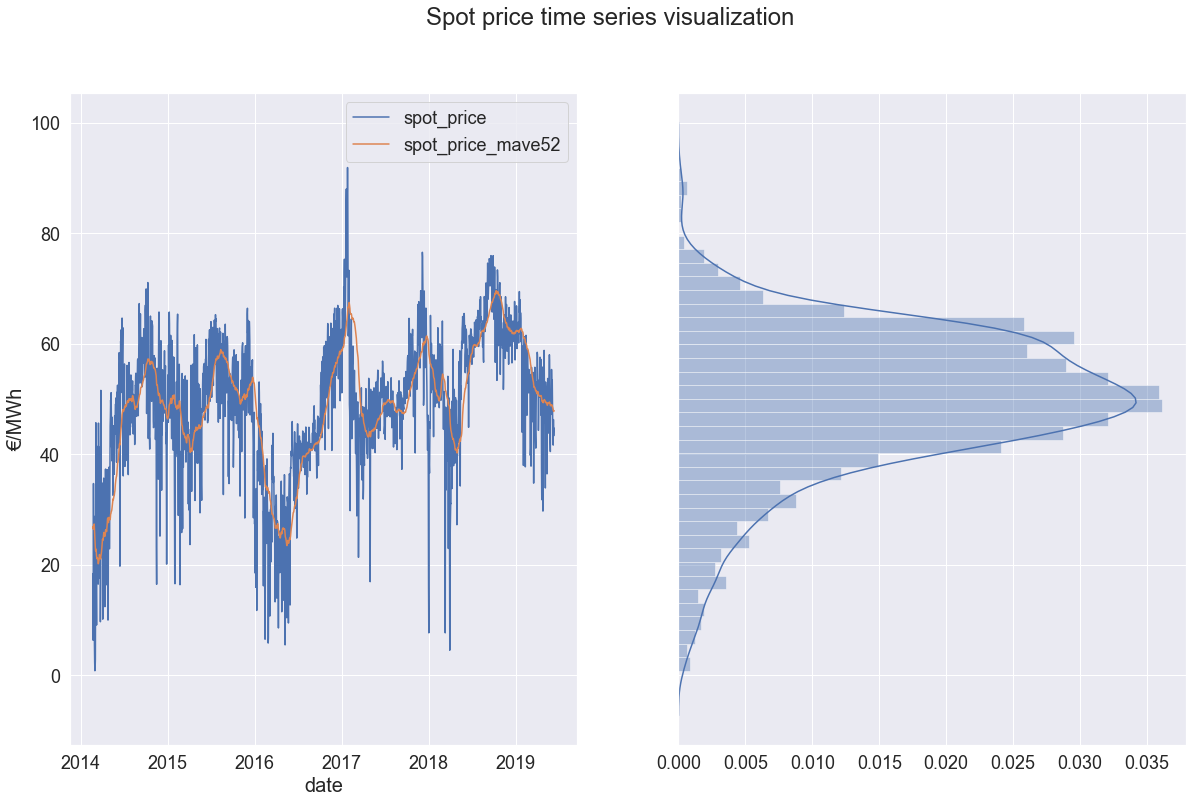

In [29]:
fig, axs = plt.subplots(1,2, sharey=True)
data_eda.plot(y=["spot_price", "spot_price_mave52"], ax=axs[0])
plt.suptitle("Spot price time series visualization")
axs[0].set_ylabel("€/MWh")

sns.distplot(data_eda["spot_price"], vertical=True, ax=axs[1])
plt.show()

### 3.1.2. Seasonality analysis

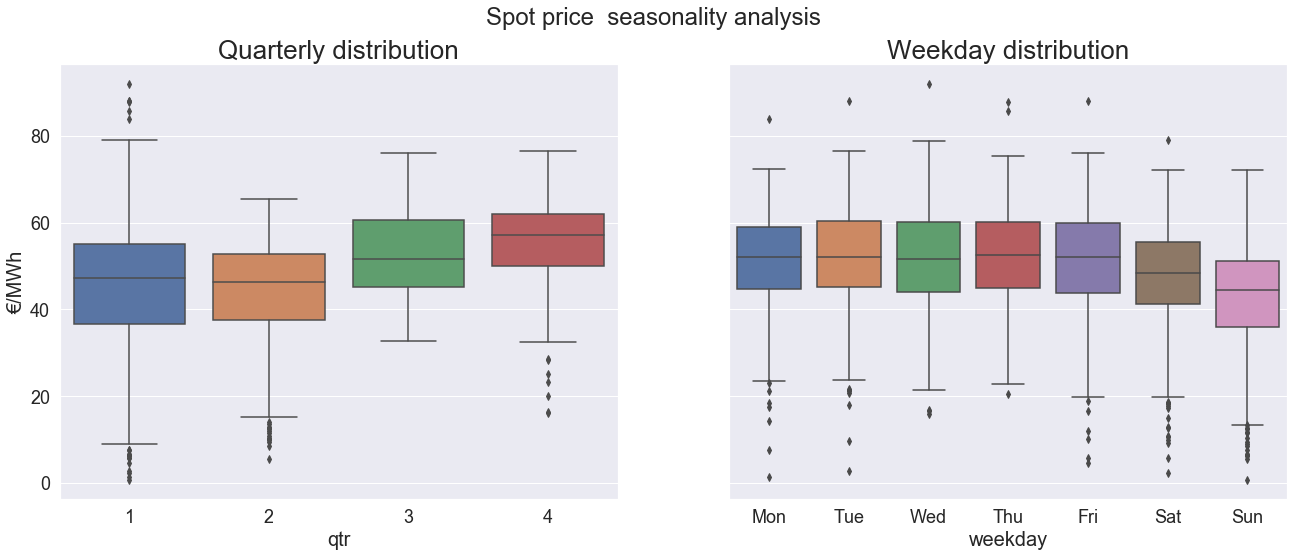

In [30]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(22,8))
sns.boxplot(x="qtr", y="spot_price", data=data_eda, ax=axs[0])
axs[0].set_title("Quarterly distribution")
axs[0].set_ylabel("€/MWh")
sns.boxplot(x="weekday", y="spot_price", data=data_eda, ax=axs[1], order=weekdays)
axs[1].set_title("Weekday distribution")
axs[1].set_ylabel("")
plt.suptitle("Spot price  seasonality analysis")
plt.show()

There are two clear seasonal patterns, one long term pattern indicating that in quarter 3 and 4 prices tend to go up, and a noticable weekly scheme pointing out that in weekends, prices decrease (on average)

Rather than performing a traditional time series analysis, let's figure out what variables are driving this seasonal differences. Is demand (measured by energy generated) behind these differences?

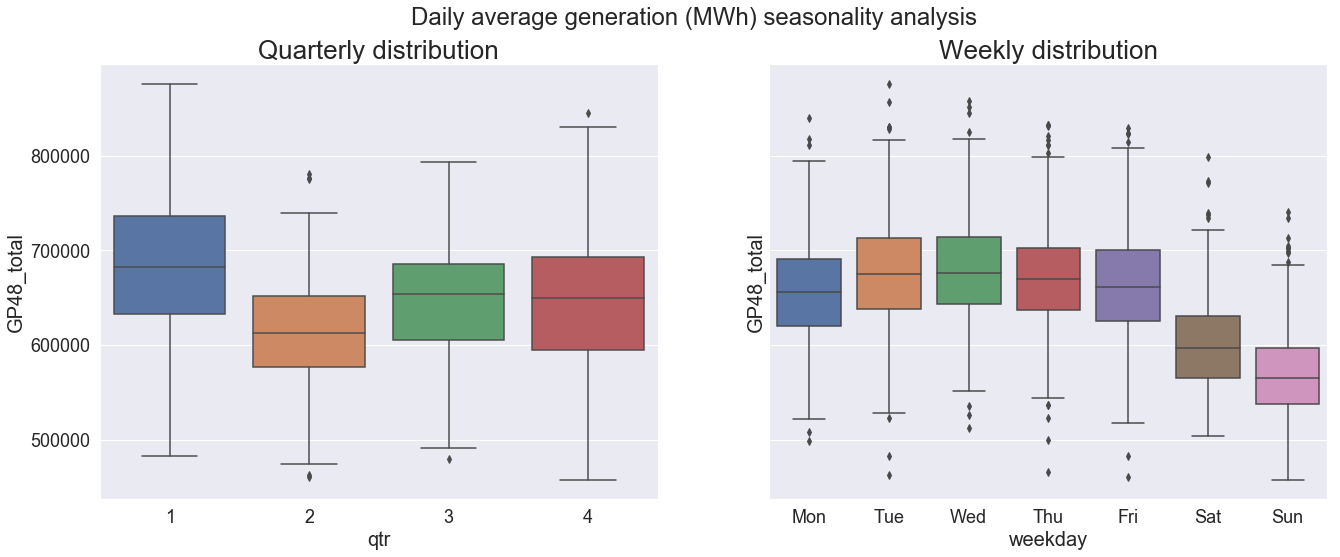

In [31]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(22,8))
sns.boxplot(x="qtr", y="GP48_total", data=data_eda, ax=axs[0])
axs[0].set_title("Quarterly distribution")
sns.boxplot(x="weekday", y="GP48_total", data=data_eda, ax=axs[1], order=weekdays)
axs[1].set_title("Weekly distribution")
plt.suptitle("Daily average generation (MWh) seasonality analysis")
plt.show()

Weekly seasonality is explained by a decrease in electricity demand, but there is not a clear relationship yerly level.

There are some techonologies with OPEX and very high CAPEX, like wind and hydro utilities, that tend to bid at low price because the underlying resource is intermitent. Let's check this hypothesis visually

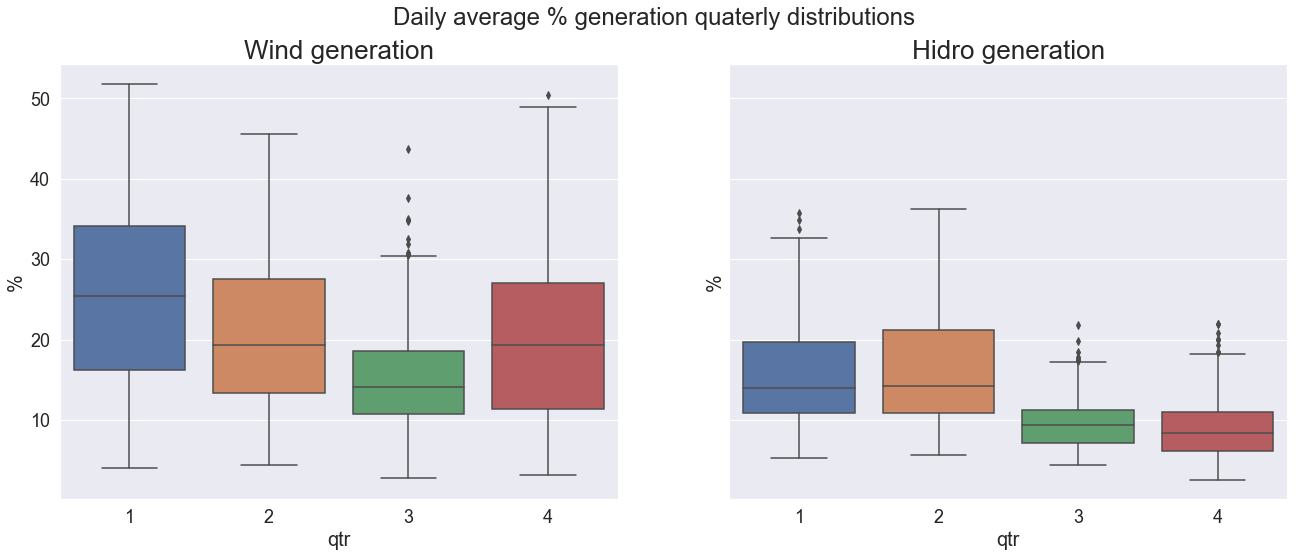

In [32]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(22,8))
sns.boxplot(x="qtr", y="GP48_wind_pct", data=data_eda, ax=axs[0])
axs[0].set_ylabel("%")
axs[0].set_title("Wind generation")
sns.boxplot(x="qtr", y="GP48_hydro_total_pct", data=data_eda, ax=axs[1])
plt.suptitle("Daily average % generation quaterly distributions")
axs[1].set_ylabel("%")
axs[1].set_title("Hidro generation")

plt.show()

As the previous plot states, spot price in quarter 3 and four is historically higher, this is mainly due an important reduction in wind and hidro generated energy. In fact, quater 1 price is almost the lowest, and demand is the highest, however, an outstading wind generation drives downs prices

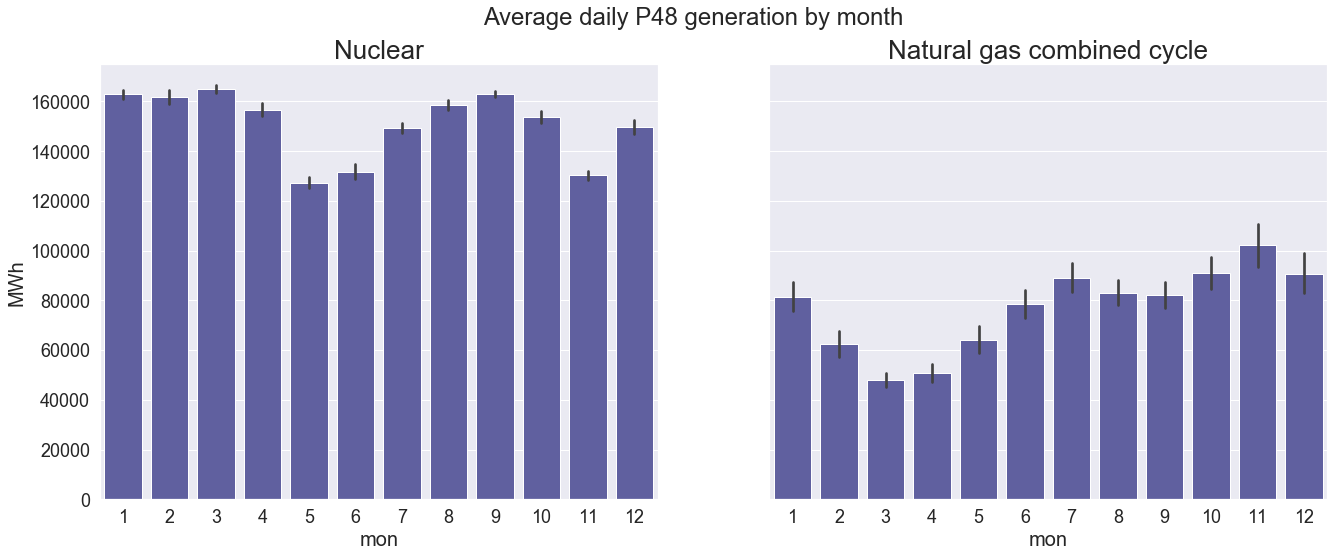

In [33]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(22,8))
sns.barplot(x="mon", y="GP48_nuclear", data=data_eda, color="blue", saturation =0.25, ax=axs[0])
axs[0].set_title("Nuclear")
axs[0].set_ylabel("MWh")
sns.barplot(x="mon", y="GP48_CC", data=data_eda, color="blue", saturation =0.25, ax=axs[1])
axs[1].set_title("Natural gas combined cycle")
axs[1].set_ylabel("")
plt.suptitle("Average daily P48 generation by month")

plt.show()

In addition, in quarters 3 and 4 there is a decrease in nuclear generation, tipically this kind of utillities (second generation Pressurized Water Reactor or PWR) halts their production twice a year to refill nuclear fuel (notice months 5 and 11). Especially, in quarter 4, this overlaps with wind and hydro generation, leading to a more expensive technologies increased generation share, like combined Cycles

### 3.1.3. Trend analysis

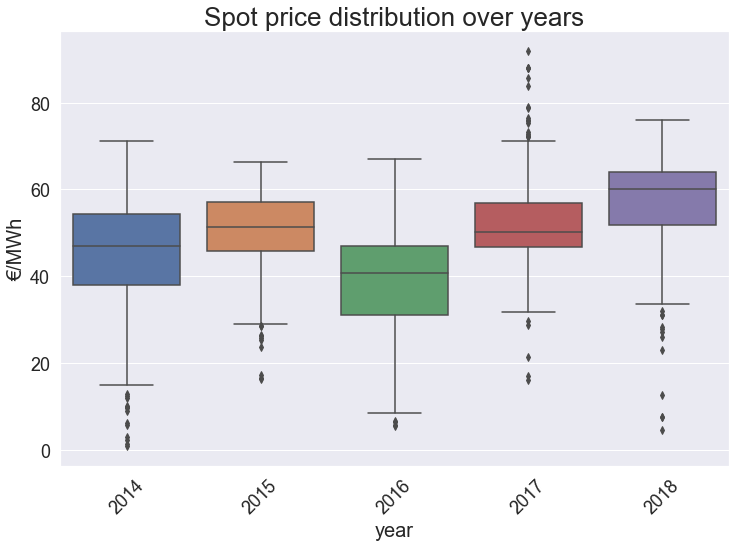

In [34]:
plt.figure(figsize=(12,8))
sns.boxplot(data=data_eda[:"2018"], x="year", y="spot_price")
plt.title("Spot price distribution over years")
plt.ylabel("€/MWh")
plt.xticks(rotation=45)
plt.show()

There is a sustained increase en yearly mean daily spot price, tendency that is only broken at 2016. Let's study this phenomenon in detail

In [35]:
agg_price = data_eda[:"2018"].groupby(["year"])["spot_price"].mean()
agg_gen = data_eda[:"2018"].groupby(["year"])["GP48_total", "GP48_wind", "GP48_hydro_total", "GP48_CC"].sum()

agg_gen["GP48_wind_hydro_year_pct"] = agg_gen[["GP48_wind", "GP48_hydro_total"]].sum(axis=1).divide(agg_gen["GP48_total"], axis=0)*100
agg_gen["GP48_CC_pct"] = agg_gen[["GP48_CC"]].sum(axis=1).divide(agg_gen["GP48_total"], axis=0)*100


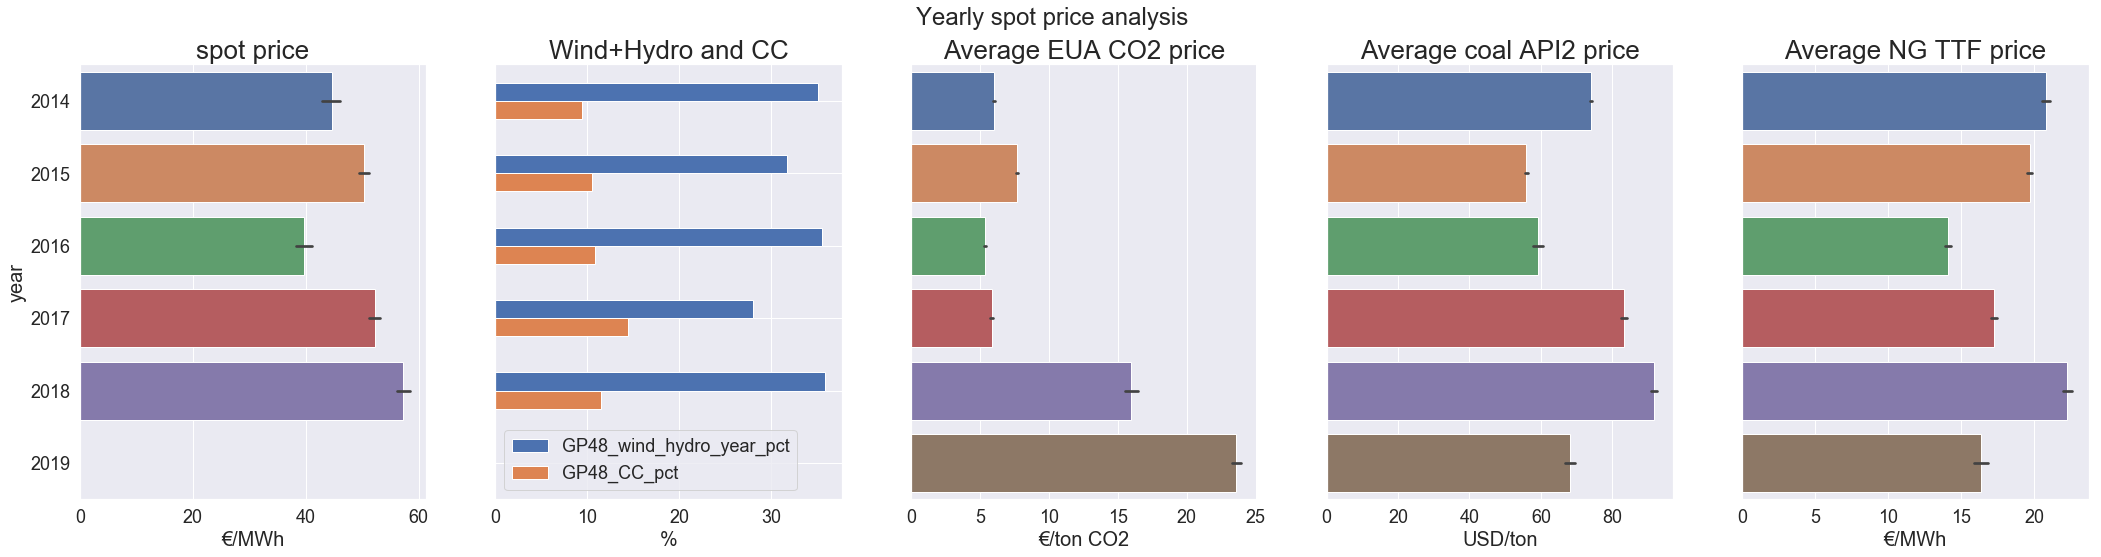

In [36]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(36,8))

plt.suptitle("Yearly spot price analysis")
sns.barplot(data=data_eda[:"2018"], x="spot_price", y="year", orient ="h", ax=axs[0])
axs[0].set_title("spot price")
axs[0].set_xlabel("€/MWh")

agg_gen.plot(y=["GP48_wind_hydro_year_pct", "GP48_CC_pct"], kind="barh", ax=axs[1])
axs[1].set_title("Wind+Hydro and CC")
axs[1].set_xlabel("%")

sns.barplot(data=data_eda, x='EUA_CO2', y="year", orient ="h",ax=axs[2])
axs[2].set_title("Average EUA CO2 price")
axs[2].set_xlabel("€/ton CO2")

sns.barplot(data=data_eda, x='coal_API2', y="year", orient ="h",ax=axs[3])
axs[3].set_title("Average coal API2 price")
axs[3].set_xlabel("USD/ton")

sns.barplot(data=data_eda, x='NG_TTF', y="year", orient ="h",ax=axs[4])
axs[4].set_title("Average NG TTF price")
axs[4].set_xlabel("€/MWh")

plt.show()

This array of plots points out the following insights:
* 2015 spot price was quite high compared with 2014 and 2016, due to a lower hydro+wind generation and quite high NG prices
* The cheapest year of the series is 2016, due to de fact that coal and NG prices went wodn, as well a as a strong hydro+wind generation
* In 2017 there is a remarkable increase in coal and NG prices, at the same time, a very poor hdyro+wind generation. These circumstances trigger a high spot price
* Fossil fuels upward trend continues in 2018 and a sharp increase in EUA CO2 prices also takes place. These two effects cannot be counterbalanced by a recovery in hydro+wind generation

Let's quantify the relationship between spot price and commidities price data (fossil fuel prices and EUA CO2 prices)


In [37]:
agg_qtr_fin = data_eda.groupby(["qtr_idx"])[["EUA_CO2", "coal_API2", "NG_TTF", "spot_price"]].mean()
agg_year_fin = data_eda.groupby(["year"])[["EUA_CO2", "coal_API2", "NG_TTF", "spot_price"]].mean().apply(np.log)

In [38]:
agg_qtr_fin.head() 

,EUA_CO2,coal_API2,NG_TTF,spot_price
qtr_idx,,,,
20141,6.265000,75.148077,23.148795,25.093128
20142,5.304505,74.782967,19.268879,39.960879
20143,6.082065,75.403533,19.185516,52.265756
20144,6.641522,71.713859,22.958957,49.829974
20151,7.015667,59.786111,21.150644,45.865865


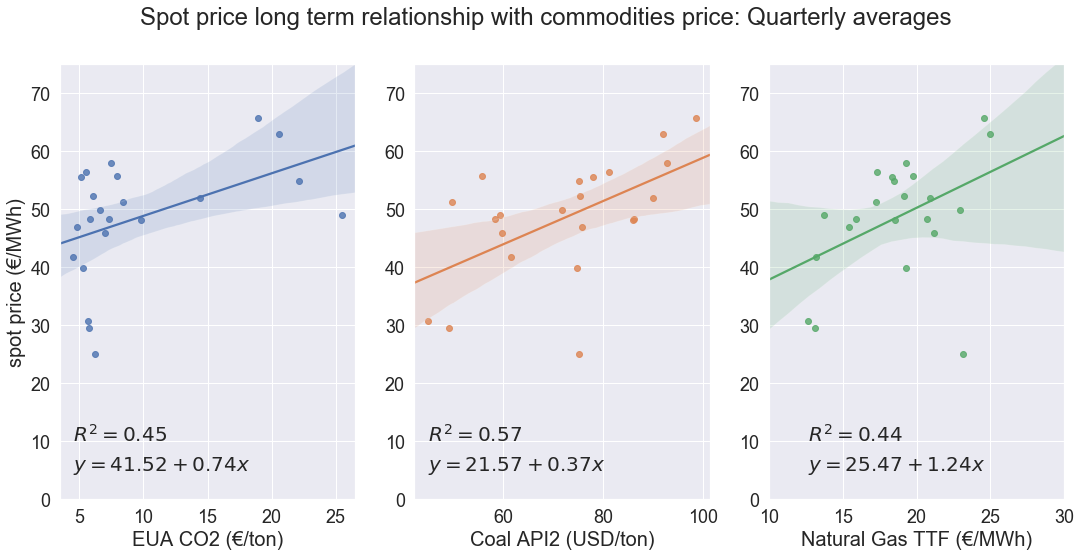

In [39]:
fig, axs = plt.subplots(1,3, sharey=False, sharex=False, figsize=(18,8))

plt.suptitle("Spot price long term relationship with commodities price: Quarterly averages")
sns.regplot(data=agg_qtr_fin, x="EUA_CO2", y="spot_price", ax=axs[0])
axs[0].set_ylim(0,75)
axs[0].set_ylabel("spot price (€/MWh)")
axs[0].set_xlabel("EUA CO2 (€/ton)")
sns.regplot(data=agg_qtr_fin, x="coal_API2", y="spot_price", ax=axs[1])
axs[1].set_ylim(0,75)
axs[1].set_ylabel("")
axs[1].set_xlabel("Coal API2 (USD/ton)")
sns.regplot(data=agg_qtr_fin, x="NG_TTF", y="spot_price", ax=axs[2])
axs[2].set_xlim(10,30)
axs[2].set_ylim(0,75)
axs[2].set_ylabel("")
axs[2].set_xlabel("Natural Gas TTF (€/MWh)")

for idx, col in enumerate(["EUA_CO2", "coal_API2", "NG_TTF"]):
    corner_idx=agg_qtr_fin[col].min()
    slope, intercept, r_value, p_value, std_err = linreg(x=agg_qtr_fin[col],y=agg_qtr_fin["spot_price"])
    for msg_idx, msg in enumerate(['$y={:.2f}+{:.2f}x$'.format(intercept, slope), '$R^2={:.2f}$'.format(r_value)]):
        axs[idx].text(corner_idx,(msg_idx+1)*5, msg, style='italic', ha="left")
plt.show()

This confirms that these commodities are strong spot prices drivers in long term, as regression lines are quite well fitted at quarterly aggregated data

### 3.2. Correlation Analysis

Pearson correlation indicates if two variables are linearly related. Explained visually: it is close to 1 in absolute terms if data fit well to a line, and correlation sign depends on this adjusted line slope. It is important to emphasize that other relationships rather than linear, are not properly captured by this score (try Spearman correlation).

This correlation analysis is carried out in two subset of features:
* Autocorrelation analysis
* Rolling stats: It may capture past influence in future values, as well as it may model seasonality
* Generation share by technology: It will indicate which technologies are the main price drivers
* Commodity price: As seen before, there is a relationship when data is aggregated quaterly, let's check if it might model trend pattern

### 3.2.1 Autocorrelation analysis

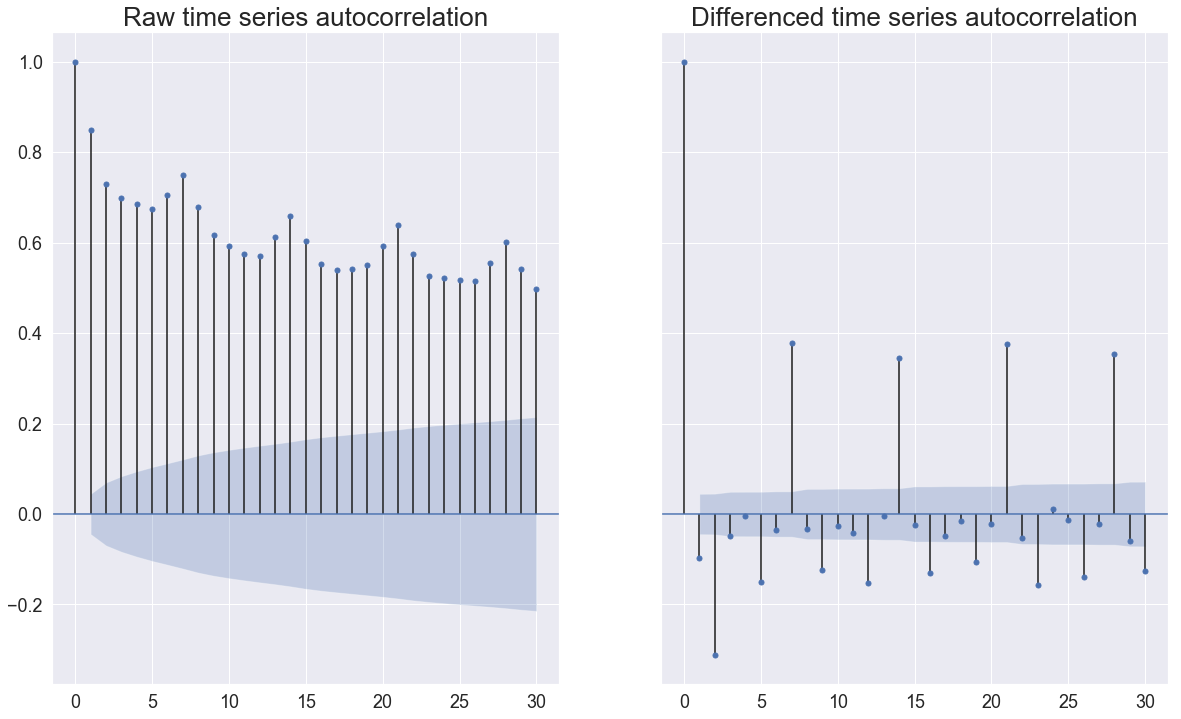

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(1,2, sharey=True)
plot_acf(data_eda["spot_price"],lags=30, ax=axs[0])
axs[0].set_title("Raw time series autocorrelation")
plot_acf(data_eda["spot_price_diff1"],lags=30, ax=axs[1])
axs[1].set_title("Differenced time series autocorrelation")
plt.show()

Taking first differences (first order), it results that Autocorrelation Plot that shows lagged values may carry useful information. ARIMA model lovers will expect a more in depth discussion, but for a ML forecasting model it is enough

#### 3.2.2 Rolling stats: Spot price

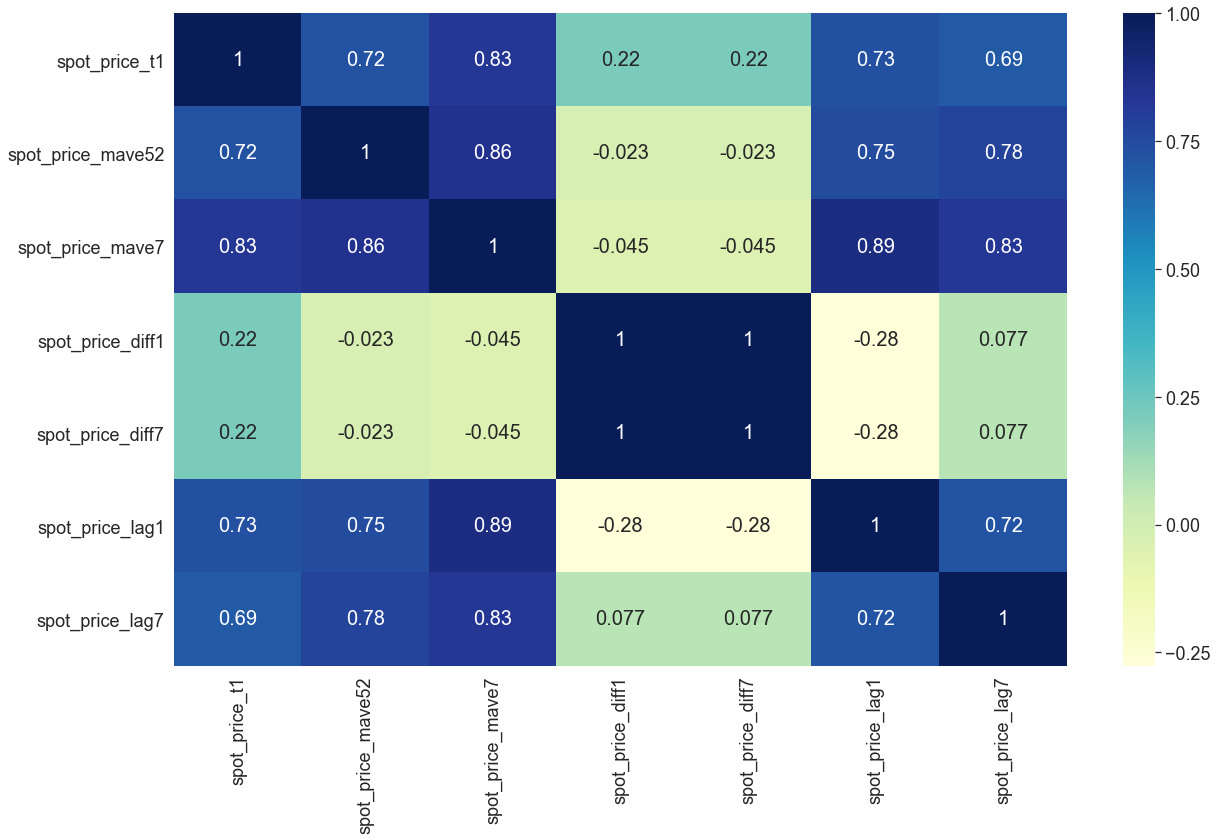

In [41]:
eda_corr2 = data_eda[["spot_price_t1"] + features_eda].corr()
sns.heatmap(eda_corr2, annot=True, cmap="YlGnBu")
plt.show()

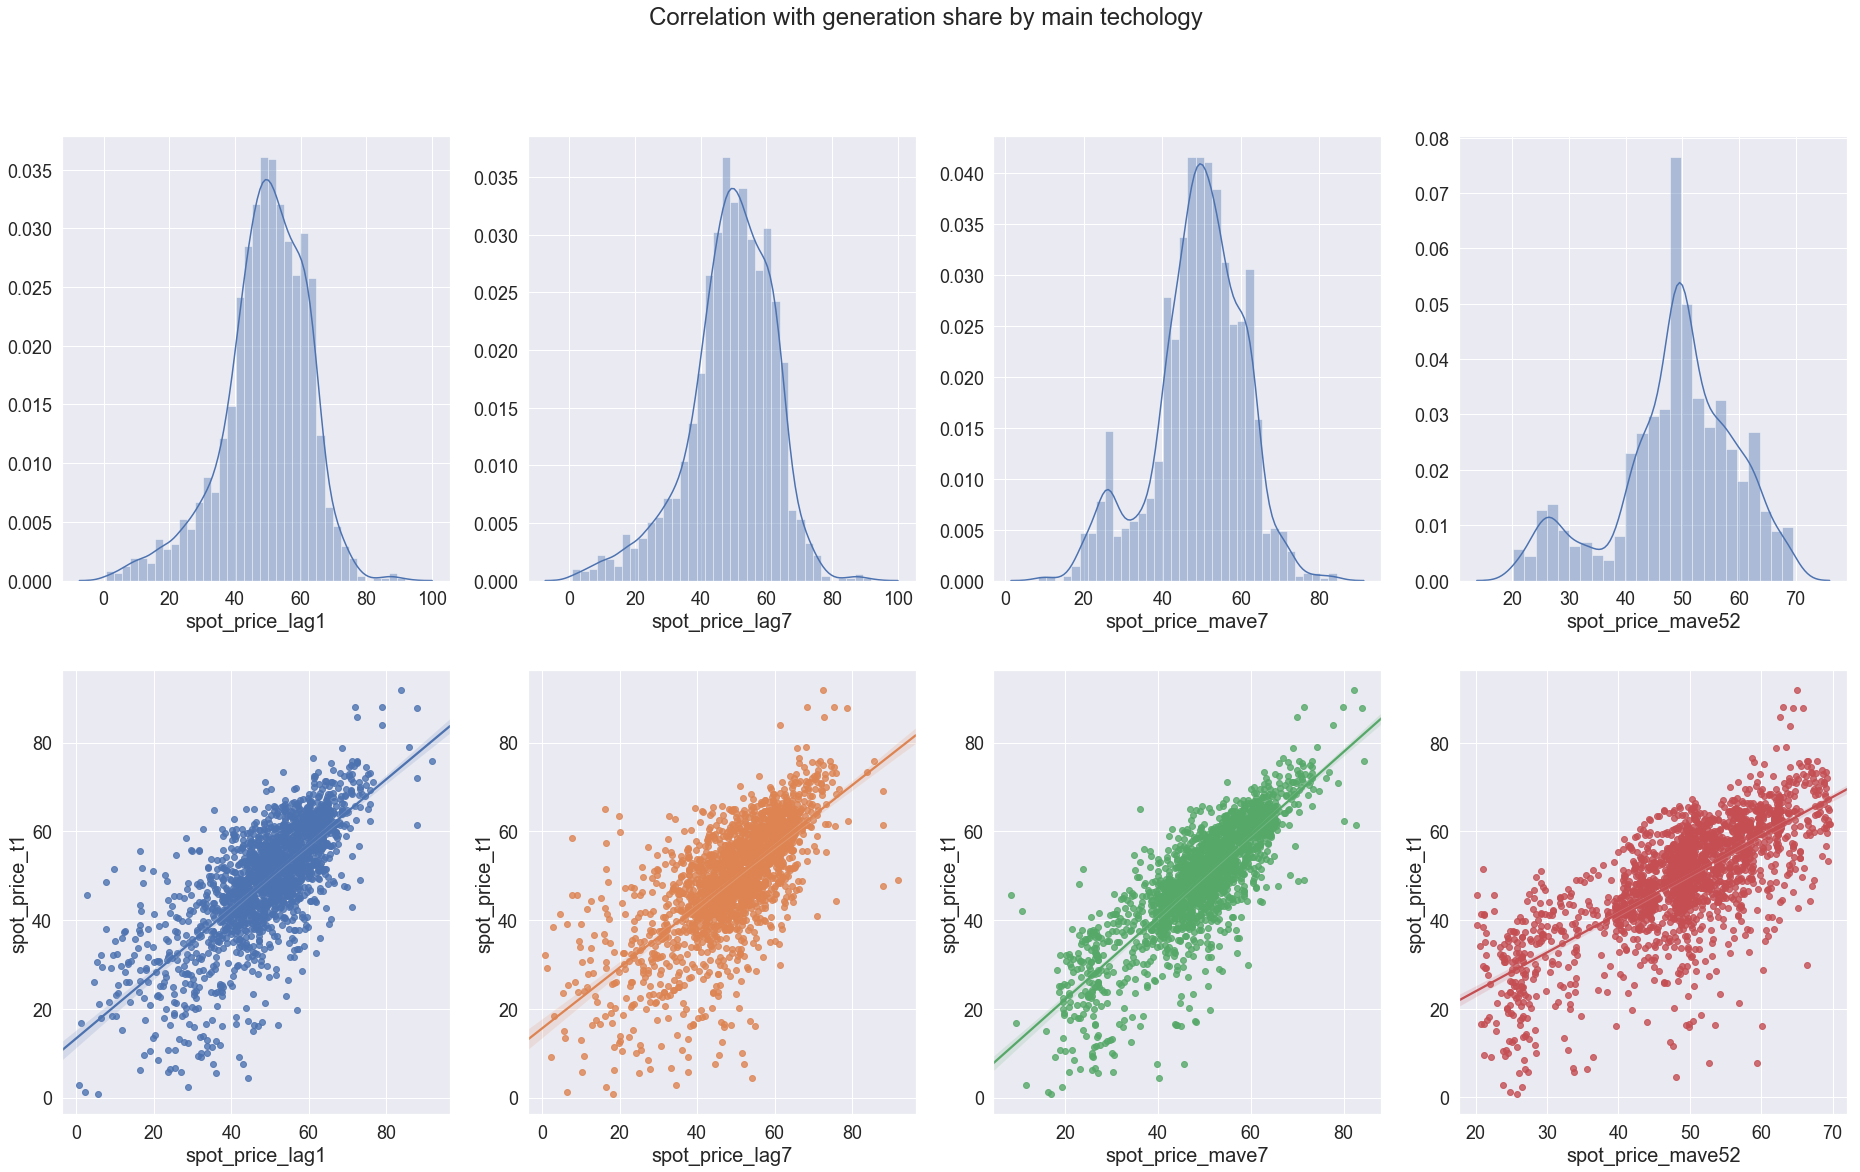

In [42]:
l =  ["spot_price_lag1","spot_price_lag7","spot_price_mave7","spot_price_mave52"]
fig, axs = plt.subplots(2,len(l), figsize=(32, 18))
for idx, col in enumerate(l):
    sns.distplot(data_eda[col], ax=axs[0,idx])
    sns.regplot(data=data_eda, x=col, y="spot_price_t1",ax=axs[1,idx])
plt.suptitle("Correlation with generation share by main techology")
plt.show()

As seen in Autocorrelation plots, there is a lot of information in lagged values, as well as in moving averages

In [43]:
data_eda[l + ["spot_price_t1"]].corr().loc[l]

,spot_price_lag1,spot_price_lag7,spot_price_mave7,spot_price_mave52,spot_price_t1
spot_price_lag1,1.000000,0.715930,0.888431,0.748540,0.732151
spot_price_lag7,0.715930,1.000000,0.827555,0.783259,0.691728
spot_price_mave7,0.888431,0.827555,1.000000,0.855846,0.827199
spot_price_mave52,0.748540,0.783259,0.855846,1.000000,0.723413


#### 3.2.3. Generation share ratio by technology

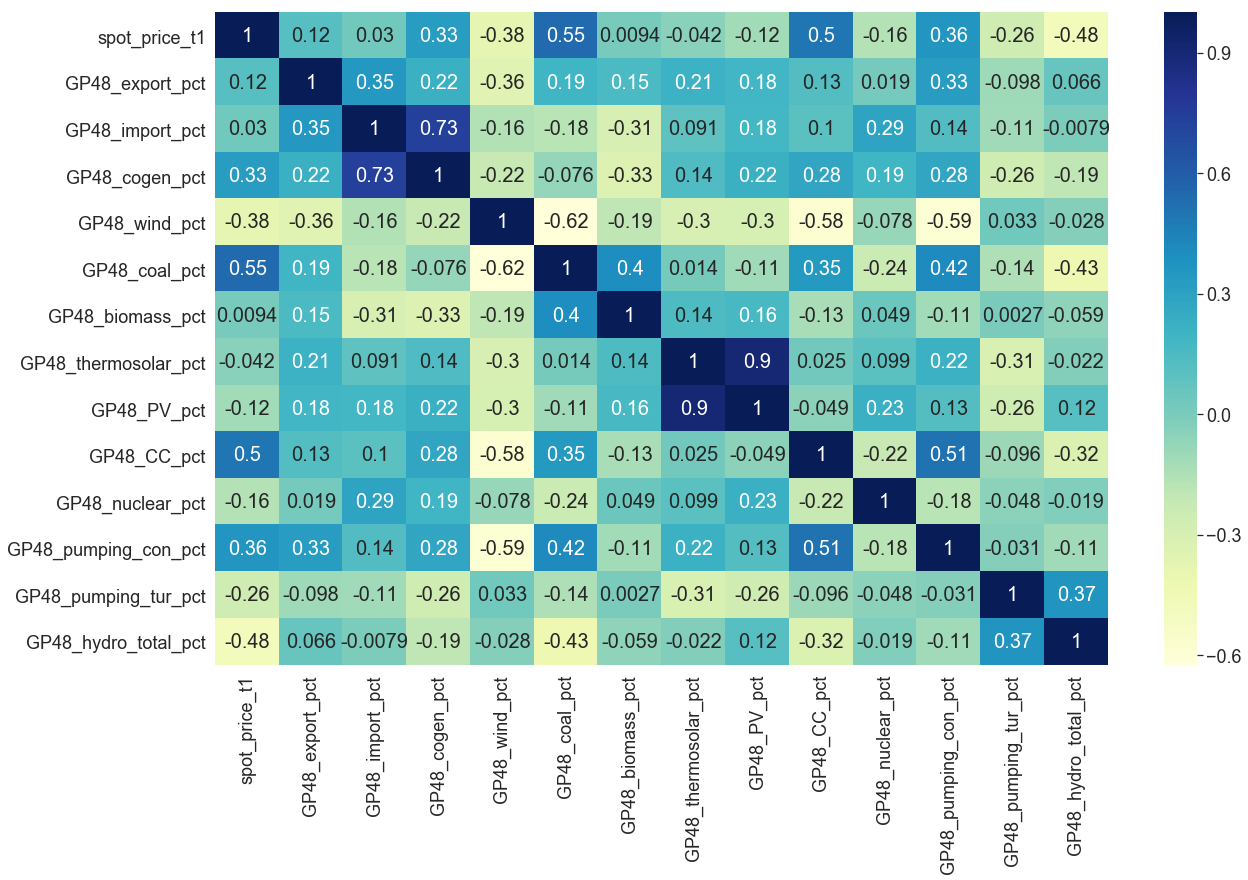

In [44]:
eda_corr1 = data_eda[["spot_price_t1"] + features_gen_pct].corr()
sns.heatmap(eda_corr1, annot=True, cmap="YlGnBu")
plt.show()

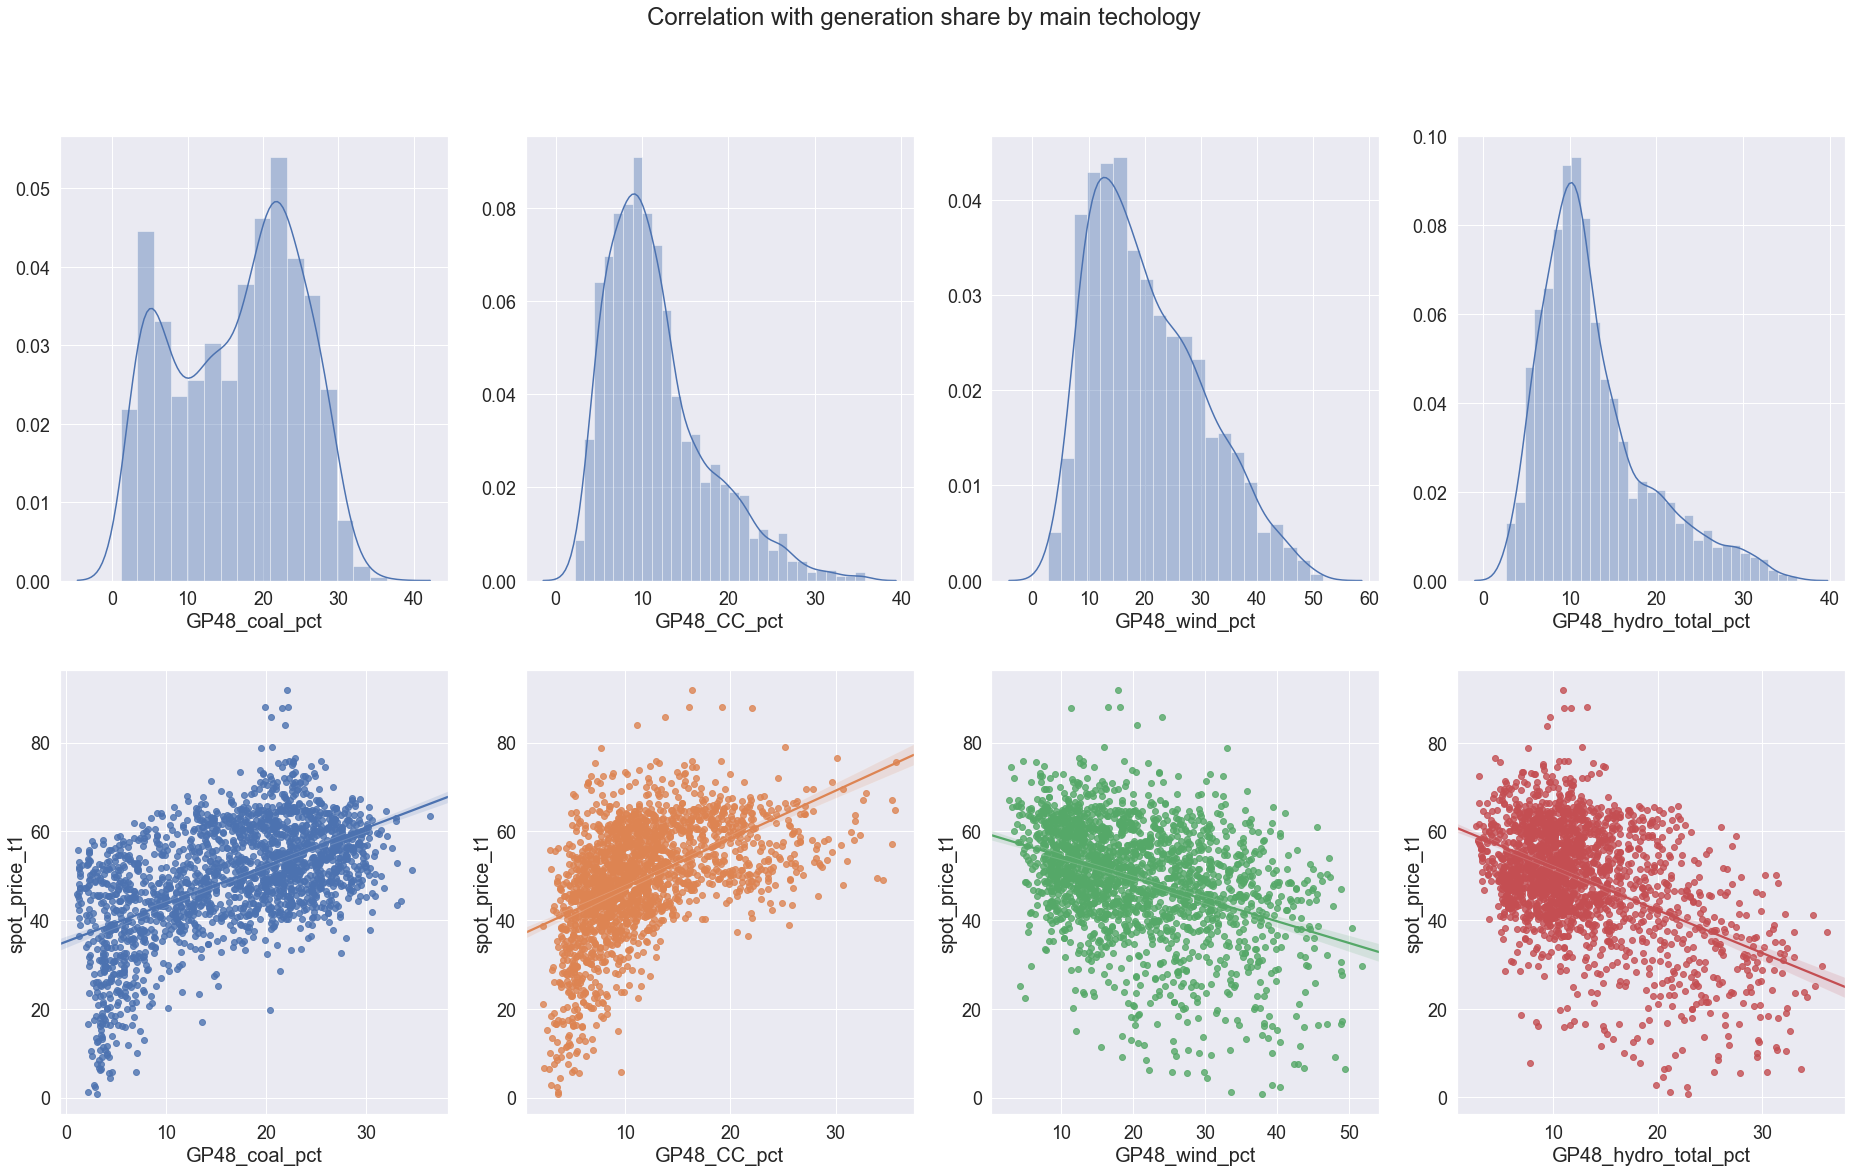

In [45]:
l =  ["GP48_coal_pct","GP48_CC_pct","GP48_wind_pct","GP48_hydro_total_pct"]
fig, axs = plt.subplots(2,len(l), figsize=(32, 18))
for idx, col in enumerate(l):
    sns.distplot(data_eda[col], ax=axs[0,idx])
    sns.regplot(data=data_eda, x=col, y="spot_price_t1",ax=axs[1,idx])
plt.suptitle("Correlation with generation share by main techology")
plt.show()

In [46]:
data_eda[l + ["spot_price_t1"]].corr().loc[l]

,GP48_coal_pct,GP48_CC_pct,GP48_wind_pct,GP48_hydro_total_pct,spot_price_t1
GP48_coal_pct,1.000000,0.346327,-0.623903,-0.429530,0.549022
GP48_CC_pct,0.346327,1.000000,-0.582522,-0.324671,0.497058
GP48_wind_pct,-0.623903,-0.582522,1.000000,-0.027707,-0.380280
GP48_hydro_total_pct,-0.429530,-0.324671,-0.027707,1.000000,-0.475594


* It is an interesting fact, that combined cycles and coal utilities yield the highest correlation scores, and an upward fit line slope. It can be seen, that the relationship is not linear, let's apply a transformation to x variable (log)
* On the other hand, wind and hydro also impact spot price but in the opposite way, as we previously explained, cost structure and resource intermitence are behind this behavior. In addition, the relationship is linear.



To ilustrate the fact that not every relationship must be linear, let's fit a log function to combined cycles data

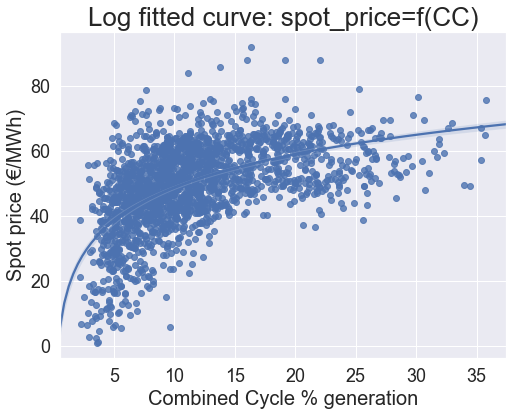

In [47]:
plt.figure(figsize=(8,6))
sns.regplot(data=data_eda, x="GP48_CC_pct", y="spot_price_t1",logx = True, fit_reg =True)
plt.ylabel("Spot price (€/MWh)")
plt.xlabel("Combined Cycle % generation")
plt.title("Log fitted curve: spot_price=f(CC)")

plt.show()

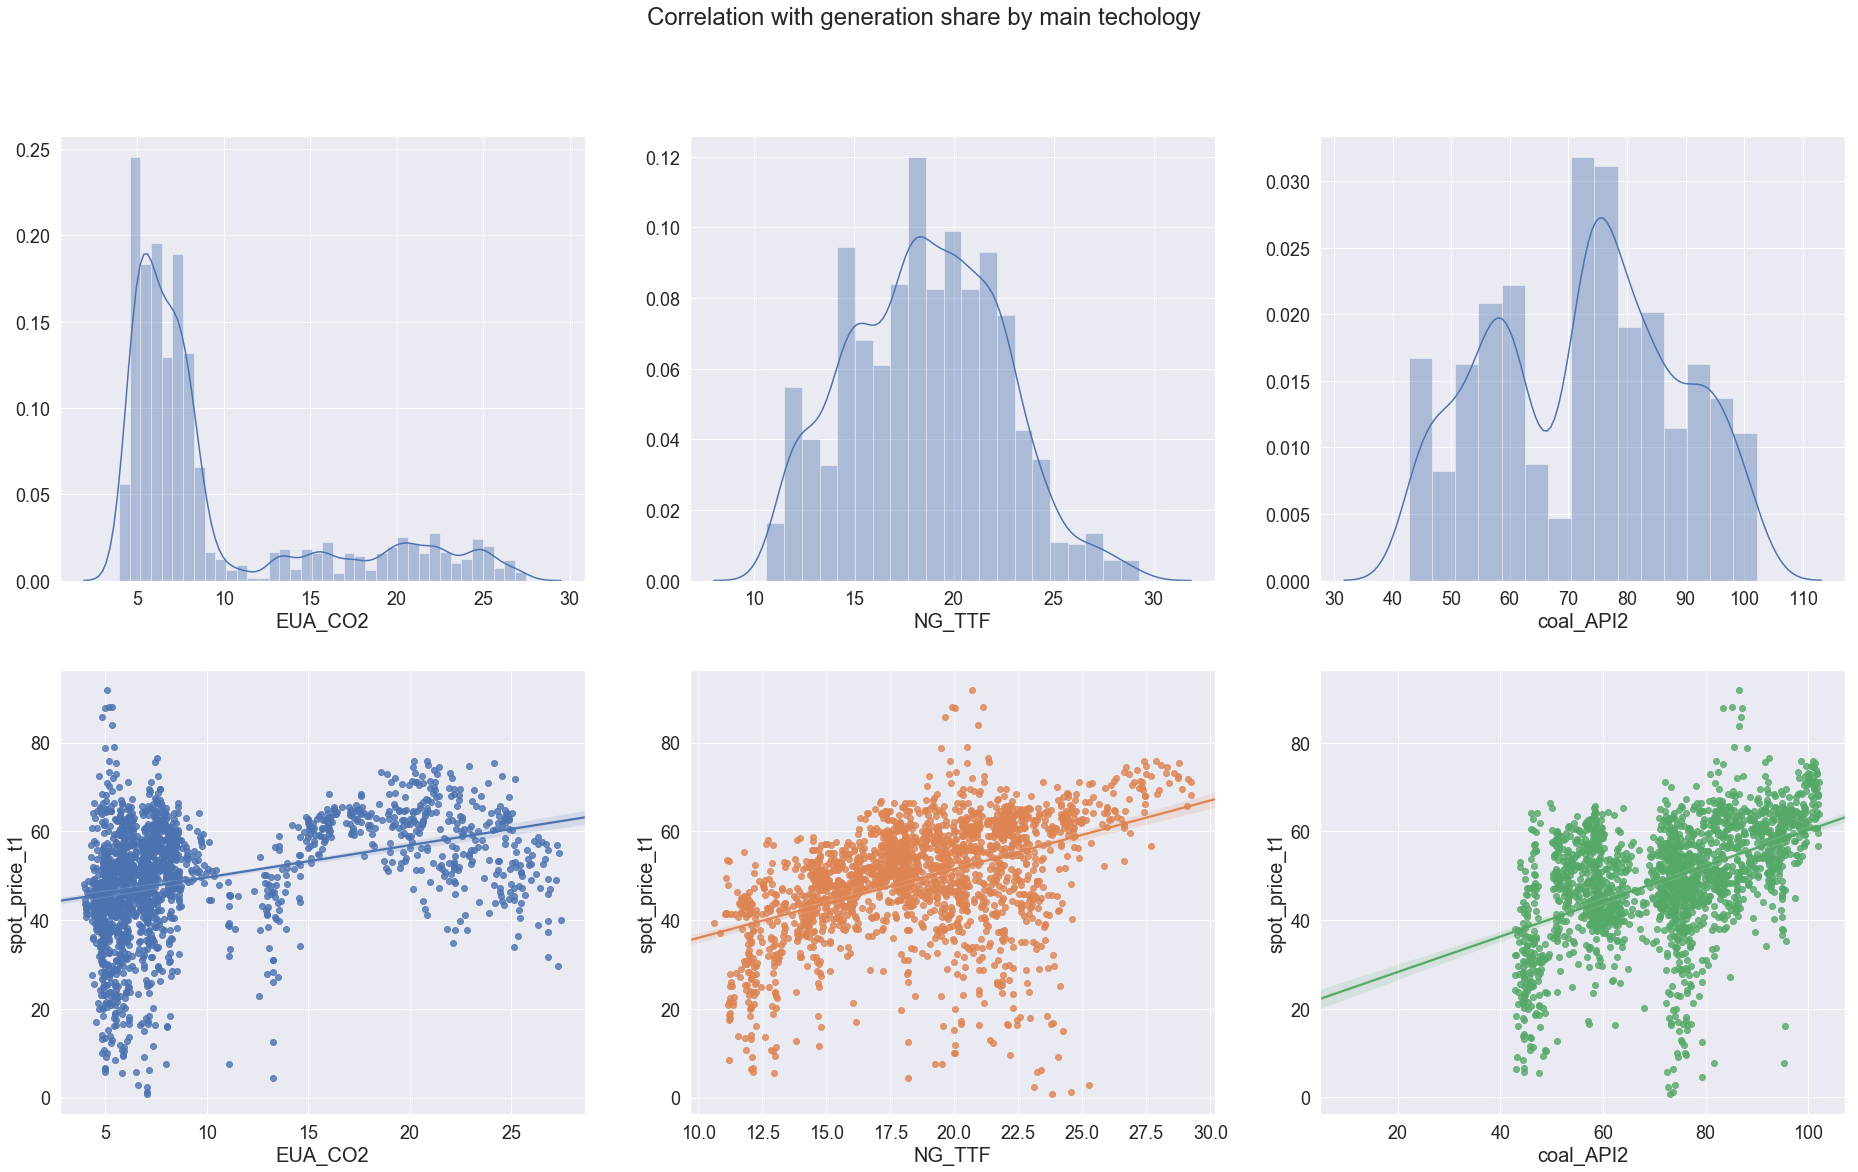

In [48]:
l =  ["EUA_CO2", "NG_TTF", "coal_API2"]
fig, axs = plt.subplots(2,len(l), sharex=False, figsize=(32, 18))
for idx, col in enumerate(l):
    sns.distplot(data_eda[col], ax=axs[0,idx])
    sns.regplot(data=data_eda, x=col, y="spot_price_t1",ax=axs[1,idx])
plt.suptitle("Correlation with generation share by main techology")
plt.show()

In [49]:
data_eda[l + ["spot_price_t1"]].corr().loc[l]

,EUA_CO2,NG_TTF,coal_API2,spot_price_t1
EUA_CO2,1.000000,0.312167,0.295966,0.346717
NG_TTF,0.312167,1.000000,0.549539,0.454133
coal_API2,0.295966,0.549539,1.000000,0.492247


As we could see in the last section, this variables influence at quarterly level is quite high, and the correlation score maintains at dailiy level, although data is very scattered around regresion line, due to seasonal (weekly and yearly patterns) and variability due to trend. A complex enough algorithm must device a way to combine seasonal and trend features in order to deal with this time structure

# 4. Feature Exploration and Engineering

The goal of this section is to handcraft some interesting features that will significantly improve our model performance. Moreover, some automatic feature engineering will be performed to exploit EDA insigths. 

## 4.1. Wind generation

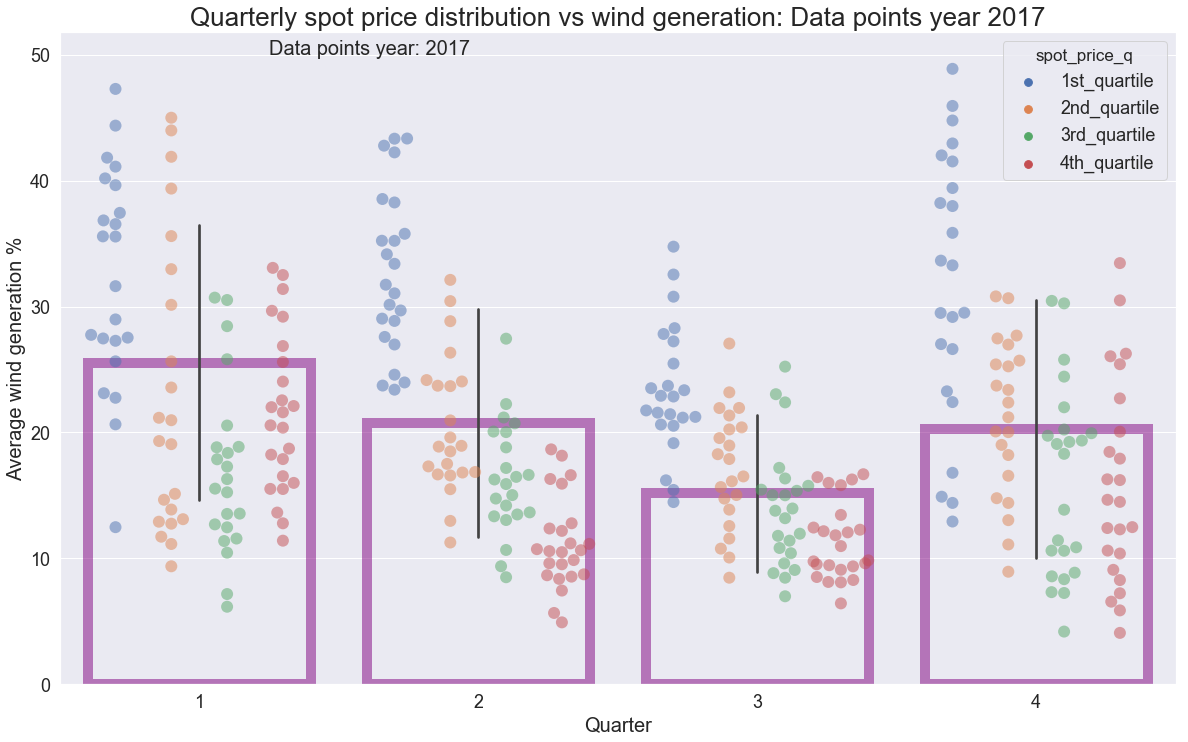

In [50]:
data_points_year= '2017'
data_pints_order=["1st_quartile", "2nd_quartile", "3rd_quartile", "4th_quartile"]

sns.barplot(x="qtr", y="GP48_wind_pct", data=data_eda, ci="sd", fill=False, edgecolor='purple', linewidth=10, alpha=.5)
sns.swarmplot(x="qtr", y="GP48_wind_pct", hue="spot_price_q", data=data_eda[data_points_year], hue_order =data_pints_order, alpha=.5, s=12, dodge=True)
plt.text(0.25,50,"Data points year: {}".format(data_points_year))

plt.ylabel("Average wind generation %")
plt.xlabel("Quarter")
plt.title("Quarterly spot price distribution vs wind generation: Data points year 2017")
plt.show()

This bar displays in bars how much generation comes from wind by quarter, computed taking averages from daily percentages. At each quarter, it is overlayed a distribution of scattered points. Those points height is daily wind generation percentage and colour represents the spot price quartile that each one belongs to. Quartiles are computed by quater and weekday (as wee saw that spot price is strongly influenced by these variables) as well as by year, because there are significant differences from one to another. Due to 

It can be clearly seen that higher points are blue and yellow, therefore they were "cheap" days that belong to lower quartiles (1st and 2nd), whereas low points are green and red, so they were expensive days when wind generation was low.

This kind of interaction will be frequent and our Machine Learning algorithm must be complex enough to model them

## 4.2. Exports and Imports

In [51]:
l = ["GP48_export_pct", "GP48_export","GP48_import_pct", "GP48_import"]
data_eda[l +  ["spot_price_t1"]].corr().loc[["spot_price_t1"], l]

,GP48_export_pct,GP48_export,GP48_import_pct,GP48_import
spot_price_t1,0.116551,0.060975,0.029714,0.047357


In [52]:
data_eda["GP48_export_mmax"] = data_eda["GP48_export"].rolling(120).min()
data_eda["GP48_import_mmax"] = data_eda["GP48_import"].rolling(120).max()
data_eda["GP48_export_pct_mave"] = data_eda["GP48_export_pct"].rolling(180).mean()
data_eda["GP48_import_pct_mave"] = data_eda["GP48_import_pct"].rolling(180).mean()

data_eda["GP48_export_pct_over_mmax"] = data_eda["GP48_export"].div(data_eda["GP48_export_mmax"])
data_eda["GP48_import_pct_over_mmax"] = data_eda["GP48_import"].div(data_eda["GP48_import_mmax"])
data_eda[["spot_price_t1", "GP48_export_pct_over_mmax","GP48_export_mmax", "GP48_export_pct_mave",
          "GP48_import_pct_over_mmax", "GP48_import_mmax", "GP48_import_pct_mave"]].corr()

,spot_price_t1,GP48_export_pct_over_mmax,GP48_export_mmax,GP48_export_pct_mave,GP48_import_pct_over_mmax,GP48_import_mmax,GP48_import_pct_mave
spot_price_t1,1.000000,0.070043,0.277427,0.349101,0.001060,-0.030416,0.096927
GP48_export_pct_over_mmax,0.070043,1.000000,0.303164,0.157999,-0.547495,-0.273358,-0.289266
GP48_export_mmax,0.277427,0.303164,1.000000,0.525269,-0.081232,-0.575958,-0.425669
GP48_export_pct_mave,0.349101,0.157999,0.525269,1.000000,-0.119027,-0.084988,0.057808
GP48_import_pct_over_mmax,0.001060,-0.547495,-0.081232,-0.119027,1.000000,-0.010493,0.038207
GP48_import_mmax,-0.030416,-0.273358,-0.575958,-0.084988,-0.010493,1.000000,0.885161
GP48_import_pct_mave,0.096927,-0.289266,-0.425669,0.057808,0.038207,0.885161,1.000000


In [53]:
data_eda[[ "GP48_export_pct","GP48_export_pct_mave"]].corr()

,GP48_export_pct,GP48_export_pct_mave
GP48_export_pct,1.000000,0.101676
GP48_export_pct_mave,0.101676,1.000000


In [54]:
features_eng =  ["GP48_export_pct_mave180"]
data["GP48_export_pct_mave180"] = data["GP48_export_pct"].rolling(180).mean()

As raw data, exports and imports are not good predictors, however, trying to compute this figure as percentage over rolling maximum does not yield better results. However exports rolling 120-days max seems to be the best engineering feature, especially at extreme values. This makes senses, since the higher the price, the lower chances to export energy to other markets linke French one, where prices are usually lower.

## 4.3. Pumping: Turbination and Consumption

In [55]:
l = ["GP48_pumping_con_pct", "GP48_pumping_con","GP48_pumping_tur_pct", "GP48_pumping_tur"]
data_eda[l +  ["spot_price_t1"]].corr().loc[["spot_price_t1"], l]

,GP48_pumping_con_pct,GP48_pumping_con,GP48_pumping_tur_pct,GP48_pumping_tur
spot_price_t1,0.36493,0.374949,-0.260594,-0.232785


In [56]:
data_eda["GP48_pumping_con_mmax"] = data_eda["GP48_pumping_con"].rolling(240).min()
data_eda["GP48_pumping_tur_mmax"] = data_eda["GP48_pumping_tur"].rolling(240).max()
data_eda["GP48_pumping_con_pct_mave"] = data_eda["GP48_pumping_con_pct"].rolling(180).mean()
data_eda["GP48_pumping_tur_pct_mave"] = data_eda["GP48_pumping_tur_pct"].rolling(7).mean()


data_eda["GP48_pumping_con_pct_over_mmax"] = data_eda["GP48_pumping_con"].div(data_eda["GP48_pumping_con_mmax"])
data_eda["GP48_pumping_tur_pct_over_mmax"] = data_eda["GP48_pumping_tur"].div(data_eda["GP48_pumping_tur_mmax"])

data_eda[["GP48_pumping_con_pct_over_mmax", "GP48_pumping_con_mmax", "GP48_pumping_con_pct_mave",
          "GP48_pumping_tur_pct_over_mmax", "GP48_pumping_tur_mmax", "GP48_pumping_tur_pct_mave", 
          "spot_price_t1"]].corr()[["spot_price_t1"]].T

,GP48_pumping_con_pct_over_mmax,GP48_pumping_con_mmax,GP48_pumping_con_pct_mave,GP48_pumping_tur_pct_over_mmax,GP48_pumping_tur_mmax,GP48_pumping_tur_pct_mave,spot_price_t1
spot_price_t1,-0.349581,-0.100548,0.611203,-0.134805,-0.291496,-0.496412,1.0


In [57]:
data_eda[["GP48_pumping_con_pct","GP48_pumping_tur_pct", "GP48_pumping_con_pct_mave","GP48_pumping_tur_pct_mave",
         "GP48_pumping_con_pct_over_mmax", "GP48_pumping_tur_pct_over_mmax"]].corr()

,GP48_pumping_con_pct,GP48_pumping_tur_pct,GP48_pumping_con_pct_mave,GP48_pumping_tur_pct_mave,GP48_pumping_con_pct_over_mmax,GP48_pumping_tur_pct_over_mmax
GP48_pumping_con_pct,1.000000,-0.031009,0.170338,-0.415521,-0.963207,-0.006380
GP48_pumping_tur_pct,-0.031009,1.000000,-0.222406,0.642759,0.102150,0.955880
GP48_pumping_con_pct_mave,0.170338,-0.222406,1.000000,-0.361062,-0.182601,-0.102038
GP48_pumping_tur_pct_mave,-0.415521,0.642759,-0.361062,1.000000,0.473762,0.587952
GP48_pumping_con_pct_over_mmax,-0.963207,0.102150,-0.182601,0.473762,1.000000,0.081975
GP48_pumping_tur_pct_over_mmax,-0.006380,0.955880,-0.102038,0.587952,0.081975,1.000000


In [58]:
features_eng = features_eng + ["GP48_pumping_con_pct_mave180", "GP48_pumping_tur_pct_mave7","GP48_pumping_tur_pct_over_mmax240"]

data["GP48_pumping_tur_pct_over_mmax240"] = data["GP48_pumping_tur"].div(data["GP48_pumping_tur"].rolling(240).max())
data["GP48_pumping_con_pct_mave180"] = data["GP48_pumping_con_pct"].rolling(180).mean()
data["GP48_pumping_tur_pct_mave7"] = data["GP48_pumping_tur_pct"].rolling(7).mean()

Turbining and consuming energy as raw predictors yield a good correlation, but consuming improves significantly if a percentage over max and a moving average are computed (moreover this features are not very correlated). Regarding turbined water, the best feature is to calculate a moving average (correlation almost doubles)

## 4.4. Nuclear power

In [59]:
l = ["GP48_nuclear", "GP48_nuclear_pct"]
data_eda[l +  ["spot_price_t1"]].corr().loc[["spot_price_t1"], l]

,GP48_nuclear,GP48_nuclear_pct
spot_price_t1,-0.099288,-0.162484


In [60]:
data_eda["GP48_nuclear_mmax"] = data_eda["GP48_nuclear"].rolling(180).max()
data_eda["GP48_nuclear_mave"] = data_eda["GP48_nuclear"].rolling(180).mean()
data_eda["GP48_nuclear_pct_mmax"] = data_eda["GP48_nuclear_pct"].rolling(180).max()
data_eda["GP48_nuclear_pct_mave"] = data_eda["GP48_nuclear_pct"].rolling(7).mean()

data_eda["GP48_nuclear_pct_over_mmax"] = data_eda["GP48_nuclear"].div(data_eda["GP48_nuclear_mmax"])

data_eda[["spot_price_t1", "GP48_nuclear_pct_over_mmax","GP48_nuclear","GP48_nuclear_pct", "GP48_nuclear_mmax",
          "GP48_nuclear_pct_mmax", "GP48_nuclear_mave", "GP48_nuclear_pct_mave"]].corr()

,spot_price_t1,GP48_nuclear_pct_over_mmax,GP48_nuclear,GP48_nuclear_pct,GP48_nuclear_mmax,GP48_nuclear_pct_mmax,GP48_nuclear_mave,GP48_nuclear_pct_mave
spot_price_t1,1.000000,-0.019553,-0.099288,-0.162484,-0.221646,-0.369188,-0.226345,-0.161702
GP48_nuclear_pct_over_mmax,-0.019553,1.000000,0.995540,0.709723,0.160654,-0.092428,0.051337,0.751828
GP48_nuclear,-0.099288,0.995540,1.000000,0.722679,0.252534,-0.054415,0.082163,0.766064
GP48_nuclear_pct,-0.162484,0.709723,0.722679,1.000000,0.151235,-0.077374,0.051946,0.811781
GP48_nuclear_mmax,-0.221646,0.160654,0.252534,0.151235,1.000000,0.359436,0.316438,0.181669
GP48_nuclear_pct_mmax,-0.369188,-0.092428,-0.054415,-0.077374,0.359436,1.000000,0.451044,-0.068791
GP48_nuclear_mave,-0.226345,0.051337,0.082163,0.051946,0.316438,0.451044,1.000000,0.086638
GP48_nuclear_pct_mave,-0.161702,0.751828,0.766064,0.811781,0.181669,-0.068791,0.086638,1.000000


In [61]:
features_eng = features_eng + ["GP48_nuclear_pct_mmax180"]

data["GP48_nuclear_pct_mmax180"] = data["GP48_nuclear_pct"].rolling(180).max()

Additionally to compute dayly nuclear generation share (GP48_nuclear_mave) taking rolling max also yield a good predictor (GP48_nuclear_pct_mmax), as well as a cmputing rolling average on generated nuclear energy. Moreover, correlation among these features is not very high

## 4.5. Solar Energy

In [62]:
l = ["GP48_PV", "GP48_PV_pct", "GP48_thermosolar", "GP48_thermosolar_pct"]
data_eda[l +  ["spot_price_t1"]].corr().loc[["spot_price_t1"], l]

,GP48_PV,GP48_PV_pct,GP48_thermosolar,GP48_thermosolar_pct
spot_price_t1,-0.095755,-0.116185,-0.027856,-0.04186


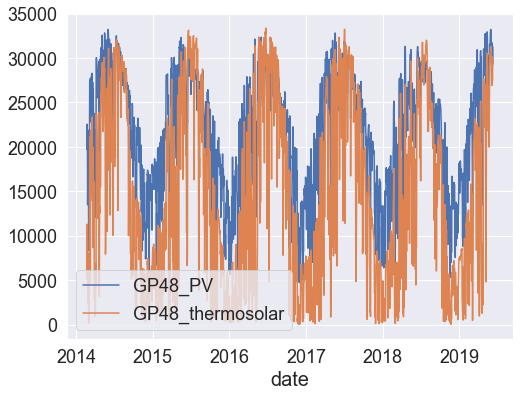

In [63]:
data_eda[["GP48_PV", "GP48_thermosolar"]].plot(figsize=(8,6))
plt.show()

In [64]:
data_eda["GP48_solar"] = data_eda[["GP48_PV", "GP48_thermosolar"]].sum(axis=1)
data_eda["GP48_solar_pct"] = data_eda["GP48_solar"].div(data_eda["GP48_total"])*100
data_eda[["spot_price_t1", "GP48_PV_pct", "GP48_thermosolar_pct", "GP48_solar", "GP48_solar_pct"]].corr()

,spot_price_t1,GP48_PV_pct,GP48_thermosolar_pct,GP48_solar,GP48_solar_pct
spot_price_t1,1.000000,-0.116185,-0.041860,-0.056241,-0.074947
GP48_PV_pct,-0.116185,1.000000,0.900487,0.912825,0.966039
GP48_thermosolar_pct,-0.041860,0.900487,1.000000,0.975156,0.982277
GP48_solar,-0.056241,0.912825,0.975156,1.000000,0.972833
GP48_solar_pct,-0.074947,0.966039,0.982277,0.972833,1.000000


In [65]:
data_eda["GP48_PV_pct_mave"] = data_eda["GP48_PV_pct"].rolling(7).mean()
data_eda["GP48_solar_pct_mave"] = data_eda["GP48_solar_pct"].rolling(7).mean()

data_eda[["spot_price_t1", "GP48_PV_pct", "GP48_thermosolar_pct", "GP48_solar", "GP48_solar_pct", "GP48_PV_pct_mave", "GP48_solar_pct_mave"]].corr()

,spot_price_t1,GP48_PV_pct,GP48_thermosolar_pct,GP48_solar,GP48_solar_pct,GP48_PV_pct_mave,GP48_solar_pct_mave
spot_price_t1,1.000000,-0.116185,-0.041860,-0.056241,-0.074947,-0.117234,-0.067940
GP48_PV_pct,-0.116185,1.000000,0.900487,0.912825,0.966039,0.877250,0.853457
GP48_thermosolar_pct,-0.041860,0.900487,1.000000,0.975156,0.982277,0.811462,0.861055
GP48_solar,-0.056241,0.912825,0.975156,1.000000,0.972833,0.837738,0.873920
GP48_solar_pct,-0.074947,0.966039,0.982277,0.972833,1.000000,0.860221,0.879425
GP48_PV_pct_mave,-0.117234,0.877250,0.811462,0.837738,0.860221,1.000000,0.974806
GP48_solar_pct_mave,-0.067940,0.853457,0.861055,0.873920,0.879425,0.974806,1.000000


Sun energy effect on Spanish market price is not very significant, this may be due to a very low installed capacity. During year 2019-2020 it is expected that this espectaculary changes, therefore marginal depresssing effect on market price may be very noticably.

My two cents on the issue:

* PV energy was heavily subsidized via Feed in Tariffs (FIT) that, at it greatest peak, a premium of 450 €/MWh was given. Nowadays, this effort is not paying off.
* On the other hand, a strong expansion of this kind of energy (withouth subsidies) is expected and it may radically change Spanish electricity market. 

## 4.6. Coal and Natural Gas

In [66]:
data_eda["GP48_CC_pct_x_TTF"] = data_eda["NG_TTF"]*data_eda["GP48_CC"]
data_eda["GP48_coal_pct_x_API2"] = data_eda["GP48_coal"]*data_eda["coal_API2"]
data_eda["GP48_coal_CC_pct_x_CO2"] = (data_eda["GP48_coal"]+data_eda["GP48_CC"])*data_eda["EUA_CO2"]

data_eda[["NG_TTF","GP48_CC_pct", "GP48_coal_pct", "coal_API2", "GP48_CC_pct_x_TTF", "GP48_coal_pct_x_API2", "GP48_coal_CC_pct_x_CO2", "spot_price_t1"]].corr()

,NG_TTF,GP48_CC_pct,GP48_coal_pct,coal_API2,GP48_CC_pct_x_TTF,GP48_coal_pct_x_API2,GP48_coal_CC_pct_x_CO2,spot_price_t1
NG_TTF,1.000000,-0.003979,0.230875,0.549539,0.360113,0.372210,0.418199,0.454133
GP48_CC_pct,-0.003979,1.000000,0.346327,0.238073,0.882892,0.459467,0.613833,0.497058
GP48_coal_pct,0.230875,0.346327,1.000000,0.128106,0.441328,0.889691,0.259188,0.549022
coal_API2,0.549539,0.238073,0.128106,1.000000,0.389119,0.470799,0.356738,0.492247
GP48_CC_pct_x_TTF,0.360113,0.882892,0.441328,0.389119,1.000000,0.626234,0.718405,0.626034
GP48_coal_pct_x_API2,0.372210,0.459467,0.889691,0.470799,0.626234,1.000000,0.402439,0.666854
GP48_coal_CC_pct_x_CO2,0.418199,0.613833,0.259188,0.356738,0.718405,0.402439,1.000000,0.619977
spot_price_t1,0.454133,0.497058,0.549022,0.492247,0.626034,0.666854,0.619977,1.000000


In [67]:
data_eda["NG_TTF_mave"] = data_eda["NG_TTF"].rolling(30).mean()
data_eda["coal_API2_mave"] = data_eda["coal_API2"].rolling(30).mean()
data_eda["EUA_CO2_mave"] = data_eda["EUA_CO2"].rolling(30).mean()
                                          
data_eda[["spot_price_t1", "NG_TTF","NG_TTF_mave", "coal_API2", "coal_API2_mave", "EUA_CO2", "EUA_CO2_mave"]].corr()

,spot_price_t1,NG_TTF,NG_TTF_mave,coal_API2,coal_API2_mave,EUA_CO2,EUA_CO2_mave
spot_price_t1,1.000000,0.454133,0.487736,0.492247,0.538136,0.346717,0.342443
NG_TTF,0.454133,1.000000,0.962108,0.549539,0.574051,0.312167,0.313167
NG_TTF_mave,0.487736,0.962108,1.000000,0.503087,0.549752,0.367563,0.368130
coal_API2,0.492247,0.549539,0.503087,1.000000,0.982525,0.295966,0.277279
coal_API2_mave,0.538136,0.574051,0.549752,0.982525,1.000000,0.343956,0.329243
EUA_CO2,0.346717,0.312167,0.367563,0.295966,0.343956,1.000000,0.991216
EUA_CO2_mave,0.342443,0.313167,0.368130,0.277279,0.329243,0.991216,1.000000


In [68]:
features_eng = features_eng + ["NG_TTF_mave30", "coal_API2_mave30", "EUA_CO2_mave30"]

data["NG_TTF_mave30"] = data["NG_TTF"].rolling(30).mean()
data["coal_API2_mave30"] = data["coal_API2"].rolling(30).mean()
data["EUA_CO2_mave30"] = data["EUA_CO2"].rolling(30).mean()

This kind of interaction yields a better correlation score, but also a higher multicollinearity, as cross features are highly correlated among themselves. In this situation, it is better to let the machine learning algorithm to figure out interactions. It is interesting to point out that this happens because commodities prices also affects to % generation

In [69]:
features_eng

['GP48_export_pct_mave180',
 'GP48_pumping_con_pct_mave180',
 'GP48_pumping_tur_pct_mave7',
 'GP48_pumping_tur_pct_over_mmax240',
 'GP48_nuclear_pct_mmax180',
 'NG_TTF_mave30',
 'coal_API2_mave30',
 'EUA_CO2_mave30']

## 4.6 Feature standardization

In [70]:
std_compute = ["spot_price", "GP48_total"]
features_std =[x + "_std" for x in std_compute]

data_raw = data[std_compute].copy()
scaler = StandardScaler().fit(data_raw)
new_cols = scaler.transform(data_raw)

for i in range(0, new_cols.shape[1]):
    data[features_std[i]] = new_cols[:,i]

data[std_compute + features_std].head()

,spot_price,GP48_total,spot_price_std,GP48_total_std
date,,,,
2014-01-01,5.808750,586167.8,-3.186907,-0.882454
2014-01-02,25.280833,642771.8,-1.738376,-0.071151
2014-01-03,39.924167,658078.5,-0.649057,0.148240
2014-01-04,4.992083,680564.6,-3.247659,0.470533
2014-01-05,4.091667,644494.7,-3.314641,-0.046456


Features are stantardize so that scale does not impact on Machine Learning algorithms performace. This can be an issue with Neural Nets, Ridge and Lasso Regression, as well as SVM or KNN algorithms. Let's check that this transformation does not change feature distribution

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


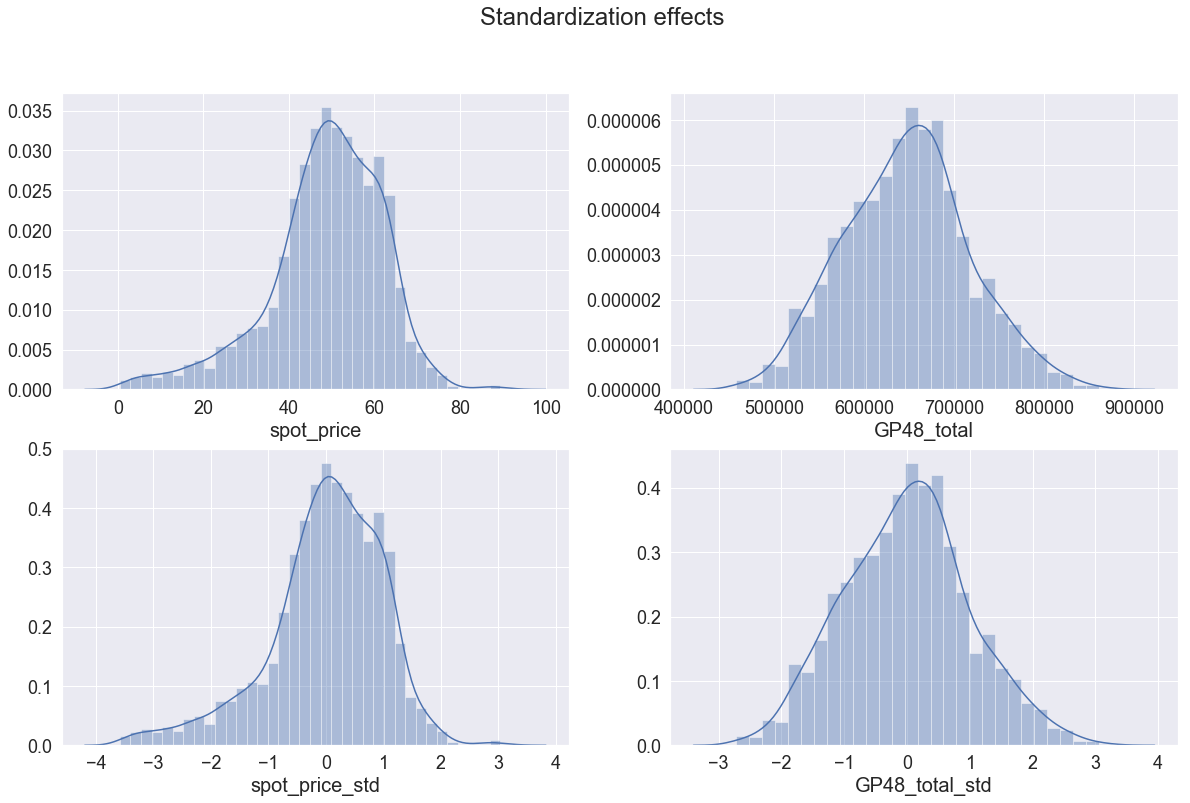

In [71]:
fig, axs = plt.subplots(2,2)
plt.suptitle("Standardization effects")
for idx, col in enumerate(std_compute):
    sns.distplot(data[col], kde=True, ax=axs[0,idx])
    
for idx, col in enumerate(features_std):
    sns.distplot(data[col],  kde=True, ax=axs[1,idx])

## 4.7. Rolling features

In [72]:
#Forecasting horizon
forecating_hor = 30
features_roll = []
targets = []

#Compute targets:
for t in range(1,forecating_hor+1):
    data["target_spot_price_t{}".format(t)] = data["spot_price"].shift(-t)
    targets.append("target_spot_price_t{}".format(t))

for feat in features_std:
    for t in [1,3,7,14]:
        data[feat + "_lag{}".format(t)] = data[feat].shift(t)
        features_roll.append(feat + "_lag{}".format(t))

#only spot price
for t in [7, 30]:
    data[["spot_price_std_mave{}".format(t), 
          "spot_price_std_mstd{}".format(t),
          "spot_price_std_mmax{}".format(t),
          "spot_price_std_mmin{}".format(t)]]\
         = data["spot_price_std"].rolling(t).agg([np.mean, np.std, np.max, np.min])
    
    features_roll = features_roll + ["spot_price_std_mave{}".format(t), 
          "spot_price_std_mstd{}".format(t),
          "spot_price_std_mmax{}".format(t),
          "spot_price_std_mmin{}".format(t)]
    
    for lag in [365]:
        data["spot_price_std_mave{}_lag{}".format(t, lag)] =\
            data["spot_price_std_mave{}".format(t)].shift(lag)
        
        features_roll.append("spot_price_std_mave{}_lag{}".format(t, lag))

In [73]:
features_full = features_time + features_gen_pct + features_eng + features_std + features_roll
features = ["feat_" + x for x in features_full]
columns =  ["year", "qtr", "mon","weekday", "flg_isWeekend"] + targets + features

feat_rename_dict = dict(zip(features_full,features))

data_fte = data.rename(columns=feat_rename_dict).dropna()[columns]

In [74]:
corr_df = data_fte[targets[0:1] + features].corr().T[targets[0:1]].loc[features]

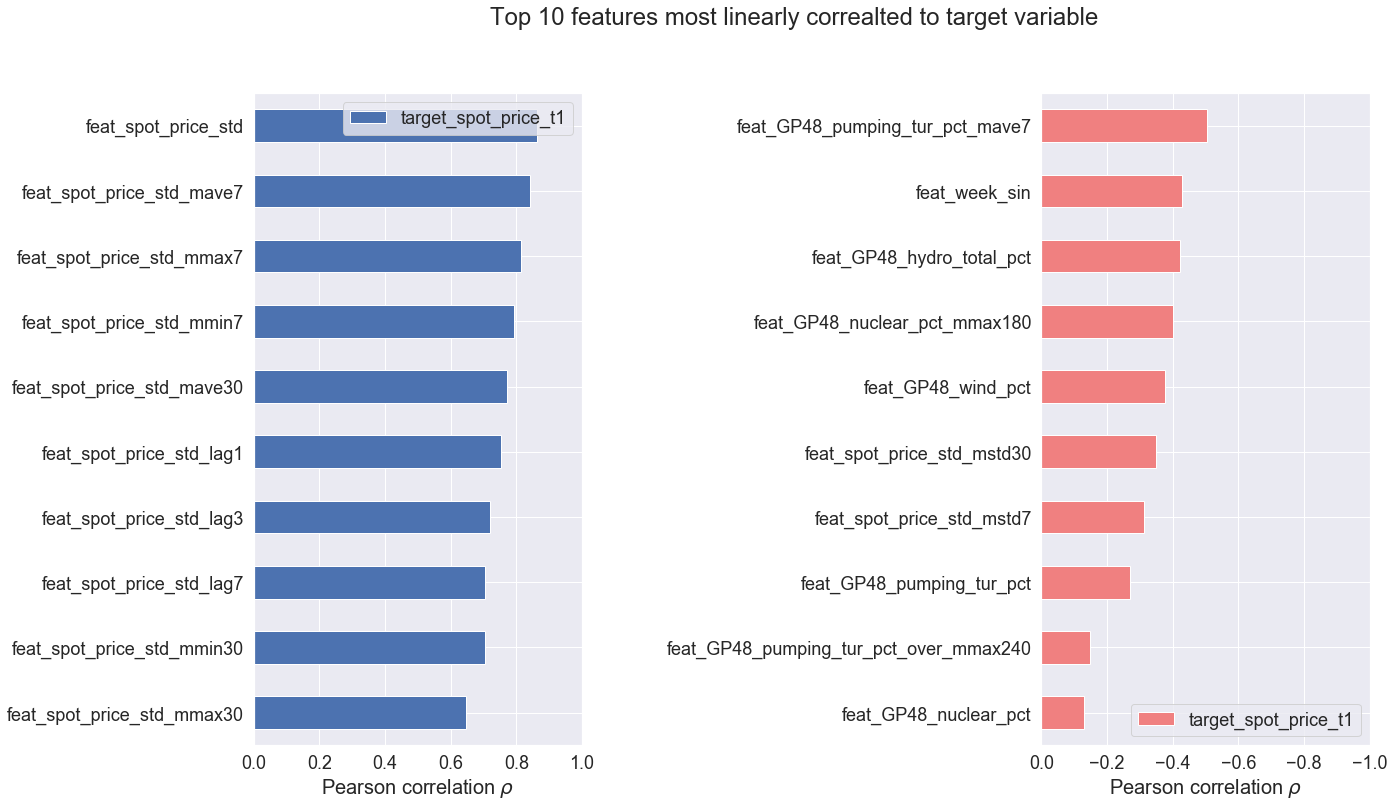

In [75]:
k_features = 10

fig, axs = plt.subplots(1,3)

corr_df_srt = corr_df.sort_values(by=["target_spot_price_t1"], ascending=False)
top_pos_corr = corr_df_srt[corr_df_srt["target_spot_price_t1"]>0].head(k_features)
top_neg_corr = corr_df_srt[corr_df_srt["target_spot_price_t1"]<0].tail(k_features)
                                                       
top_pos_corr.sort_values(by="target_spot_price_t1").plot.barh(ax=axs[0])
top_neg_corr.plot.barh(color="lightcoral", ax=axs[2])

axs[0].set_xlim(0, 1) 
axs[2].set_xlim(0, -1.)

for ax in axs:
    ax.set_xlabel(r"Pearson correlation $\rho$")
fig.delaxes(axs[1])

plt.suptitle("Top {} features most linearly correalted to target variable".format(k_features))
plt.show()

In [76]:
data_fte.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1564 entries, 2015-01-30 to 2019-05-12
Freq: D
Data columns (total 80 columns):
year                                      1564 non-null int64
qtr                                       1564 non-null int64
mon                                       1564 non-null int64
weekday                                   1564 non-null int64
flg_isWeekend                             1564 non-null int32
target_spot_price_t1                      1564 non-null float64
target_spot_price_t2                      1564 non-null float64
target_spot_price_t3                      1564 non-null float64
target_spot_price_t4                      1564 non-null float64
target_spot_price_t5                      1564 non-null float64
target_spot_price_t6                      1564 non-null float64
target_spot_price_t7                      1564 non-null float64
target_spot_price_t8                      1564 non-null float64
target_spot_price_t9                      156

In [77]:
data_fte.to_csv(PATH + outfile, index_label='date')